4일차 실습: 확률분포와 딥러닝 응용

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, shapiro, kstest, jarque_bera
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.datasets import make_regression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings('ignore')


In [2]:
# 시각화 설정
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

4일차 실습: 확률분포와 딥러닝 응용

실습 1: 다양한 분포 데이터 생성 및 특성 분석

In [3]:
def generate_diverse_datasets(n_samples=1000, random_state=42):
    """다양한 분포의 데이터셋 생성"""
    np.random.seed(random_state)
    
    datasets = {}
    
    # 1. 정규분포 데이터 (이상적인 경우)
    datasets['normal'] = np.random.normal(50, 15, n_samples)
    
    # 2. 로그정규분포 (소득 분포, 주택 가격 등)
    datasets['lognormal'] = np.random.lognormal(3, 0.8, n_samples)
    
    # 3. 베타분포 (비율 데이터, 확률값)
    datasets['beta'] = np.random.beta(2, 5, n_samples) * 100
    
    # 4. 지수분포 (대기시간, 생존시간)
    datasets['exponential'] = np.random.exponential(25, n_samples)
    
    # 5. 감마분포 (양의 연속값)
    datasets['gamma'] = np.random.gamma(2, 10, n_samples)
    
    # 6. 이중 모드 분포 (두 그룹이 섞인 데이터)
    mode1 = np.random.normal(30, 8, n_samples//2)
    mode2 = np.random.normal(70, 12, n_samples//2)
    datasets['bimodal'] = np.concatenate([mode1, mode2])
    
    # 7. 이상치가 포함된 데이터
    normal_part = np.random.normal(50, 10, int(n_samples*0.9))
    outliers = np.random.normal(150, 5, int(n_samples*0.1))
    datasets['with_outliers'] = np.concatenate([normal_part, outliers])
    
    return datasets

In [4]:
def analyze_distribution(data, name):
    """분포의 통계적 특성 분석"""
    print(f"\n📊 {name.upper()} 분포 분석")
    print("-" * 40)
    
    # 기본 통계량
    print(f"Mean: {np.mean(data):.3f}")
    print(f"Std: {np.std(data):.3f}")
    print(f"Min: {np.min(data):.3f}")
    print(f"Max: {np.max(data):.3f}")
    
    # 분포의 모양 특성
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    
    print(f"Skewness: {skewness:.3f}")
    if abs(skewness) < 0.5:
        print("  → Approximately symmetric")
    elif skewness > 0:
        print("  → Right-skewed (positive skew)")
    else:
        print("  → Left-skewed (negative skew)")
    
    print(f"Kurtosis: {kurtosis:.3f}")
    if abs(kurtosis) < 0.5:
        print("  → Normal kurtosis (mesokurtic)")
    elif kurtosis > 0:
        print("  → Heavy tails (leptokurtic)")
    else:
        print("  → Light tails (platykurtic)")
    
    # 정규성 검정
    if len(data) <= 5000:
        shapiro_stat, shapiro_p = shapiro(data)
        print(f"Shapiro-Wilk p-value: {shapiro_p:.6f}")
        if shapiro_p > 0.05:
            print("  → Likely normal distribution (α=0.05)")
        else:
            print("  → Not normal distribution (α=0.05)")
    
    # Jarque-Bera 검정 (큰 샘플에서 유용)
    jb_stat, jb_p = jarque_bera(data)
    print(f"Jarque-Bera p-value: {jb_p:.6f}")
    
    return {
        'mean': np.mean(data),
        'std': np.std(data),
        'skewness': skewness,
        'kurtosis': kurtosis,
        'shapiro_p': shapiro_p if len(data) <= 5000 else None,
        'jb_p': jb_p
    }

In [5]:
def visualize_distribution(data, name):
    """분포 시각화"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{name.upper()} Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. 히스토그램 + 밀도
    axes[0,0].hist(data, bins=50, alpha=0.7, density=True, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Histogram with Density')
    axes[0,0].set_xlabel('Value')
    axes[0,0].set_ylabel('Density')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Box plot
    box_plot = axes[0,1].boxplot(data, patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightcoral')
    axes[0,1].set_title('Box Plot')
    axes[0,1].set_ylabel('Value')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Q-Q plot (Normal)
    stats.probplot(data, dist="norm", plot=axes[0,2])
    axes[0,2].set_title('Q-Q Plot (Normal)')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. 누적분포함수 (ECDF)
    sorted_data = np.sort(data)
    y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    axes[1,0].plot(sorted_data, y, marker='.', linestyle='none', alpha=0.7, color='green')
    axes[1,0].set_title('Empirical CDF')
    axes[1,0].set_xlabel('Value')
    axes[1,0].set_ylabel('Cumulative Probability')
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. KDE (Kernel Density Estimation)
    axes[1,1].hist(data, bins=50, alpha=0.5, density=True, color='lightblue')
    try:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 100)
        axes[1,1].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
        axes[1,1].legend()
    except:
        pass
    axes[1,1].set_title('Histogram with KDE')
    axes[1,1].set_xlabel('Value')
    axes[1,1].set_ylabel('Density')
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. 통계 요약
    stats_text = f"""Statistics Summary:
Mean: {np.mean(data):.2f}
Std: {np.std(data):.2f}
Skewness: {stats.skew(data):.3f}
Kurtosis: {stats.kurtosis(data):.3f}
Min: {np.min(data):.2f}
Max: {np.max(data):.2f}"""
    
    axes[1,2].text(0.1, 0.5, stats_text, transform=axes[1,2].transAxes, 
                   fontsize=11, verticalalignment='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    axes[1,2].set_title('Statistics Summary')
    axes[1,2].axis('off')
    
    plt.tight_layout()
    plt.show()




🎯 실습 1: 다양한 분포 데이터 생성 및 분석

📊 NORMAL 분포 분석
----------------------------------------
Mean: 50.290
Std: 14.681
Min: 1.381
Max: 107.791
Skewness: 0.117
  → Approximately symmetric
Kurtosis: 0.066
  → Normal kurtosis (mesokurtic)
Shapiro-Wilk p-value: 0.627258
  → Likely normal distribution (α=0.05)
Jarque-Bera p-value: 0.292823


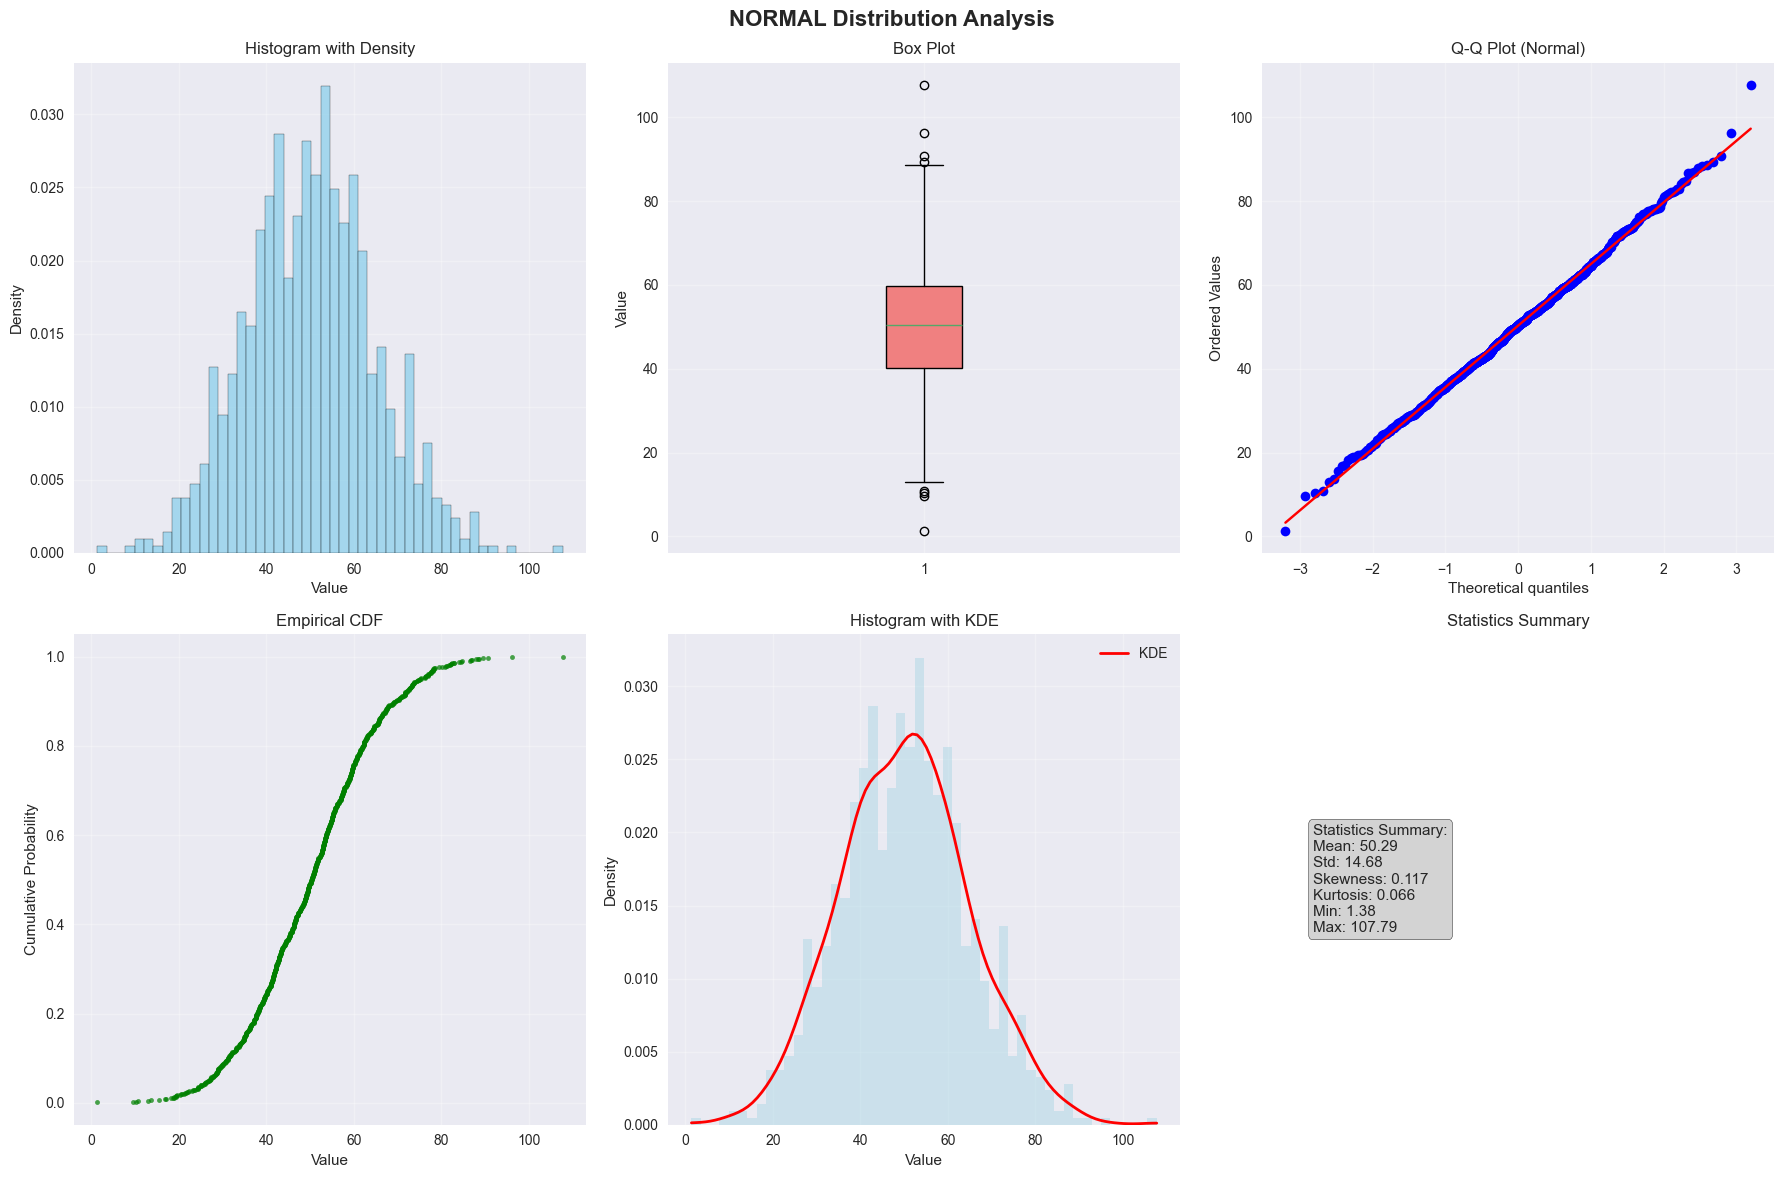


📊 LOGNORMAL 분포 분석
----------------------------------------
Mean: 29.105
Std: 26.553
Min: 1.911
Max: 258.394
Skewness: 2.903
  → Right-skewed (positive skew)
Kurtosis: 13.869
  → Heavy tails (leptokurtic)
Shapiro-Wilk p-value: 0.000000
  → Not normal distribution (α=0.05)
Jarque-Bera p-value: 0.000000


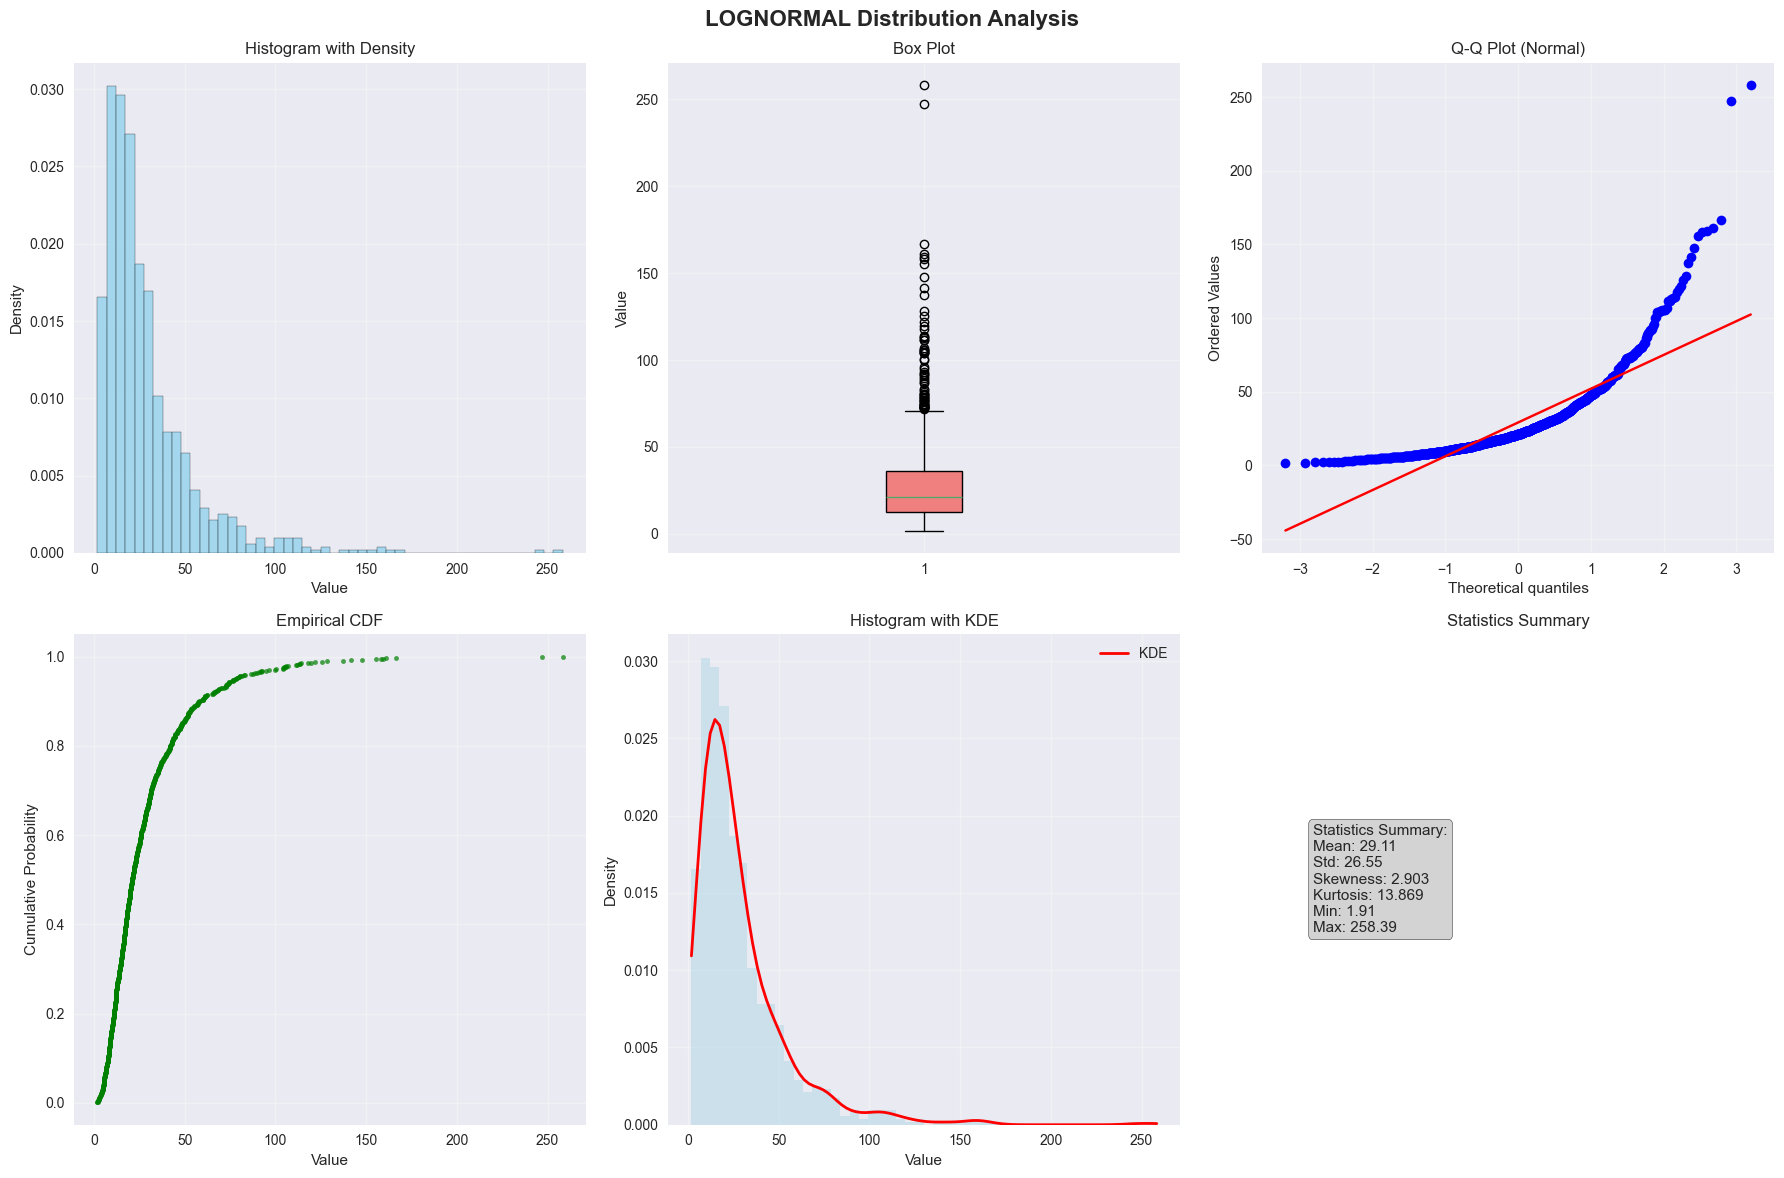


📊 BETA 분포 분석
----------------------------------------
Mean: 28.761
Std: 15.962
Min: 0.537
Max: 81.334
Skewness: 0.499
  → Approximately symmetric
Kurtosis: -0.368
  → Normal kurtosis (mesokurtic)
Shapiro-Wilk p-value: 0.000000
  → Not normal distribution (α=0.05)
Jarque-Bera p-value: 0.000000


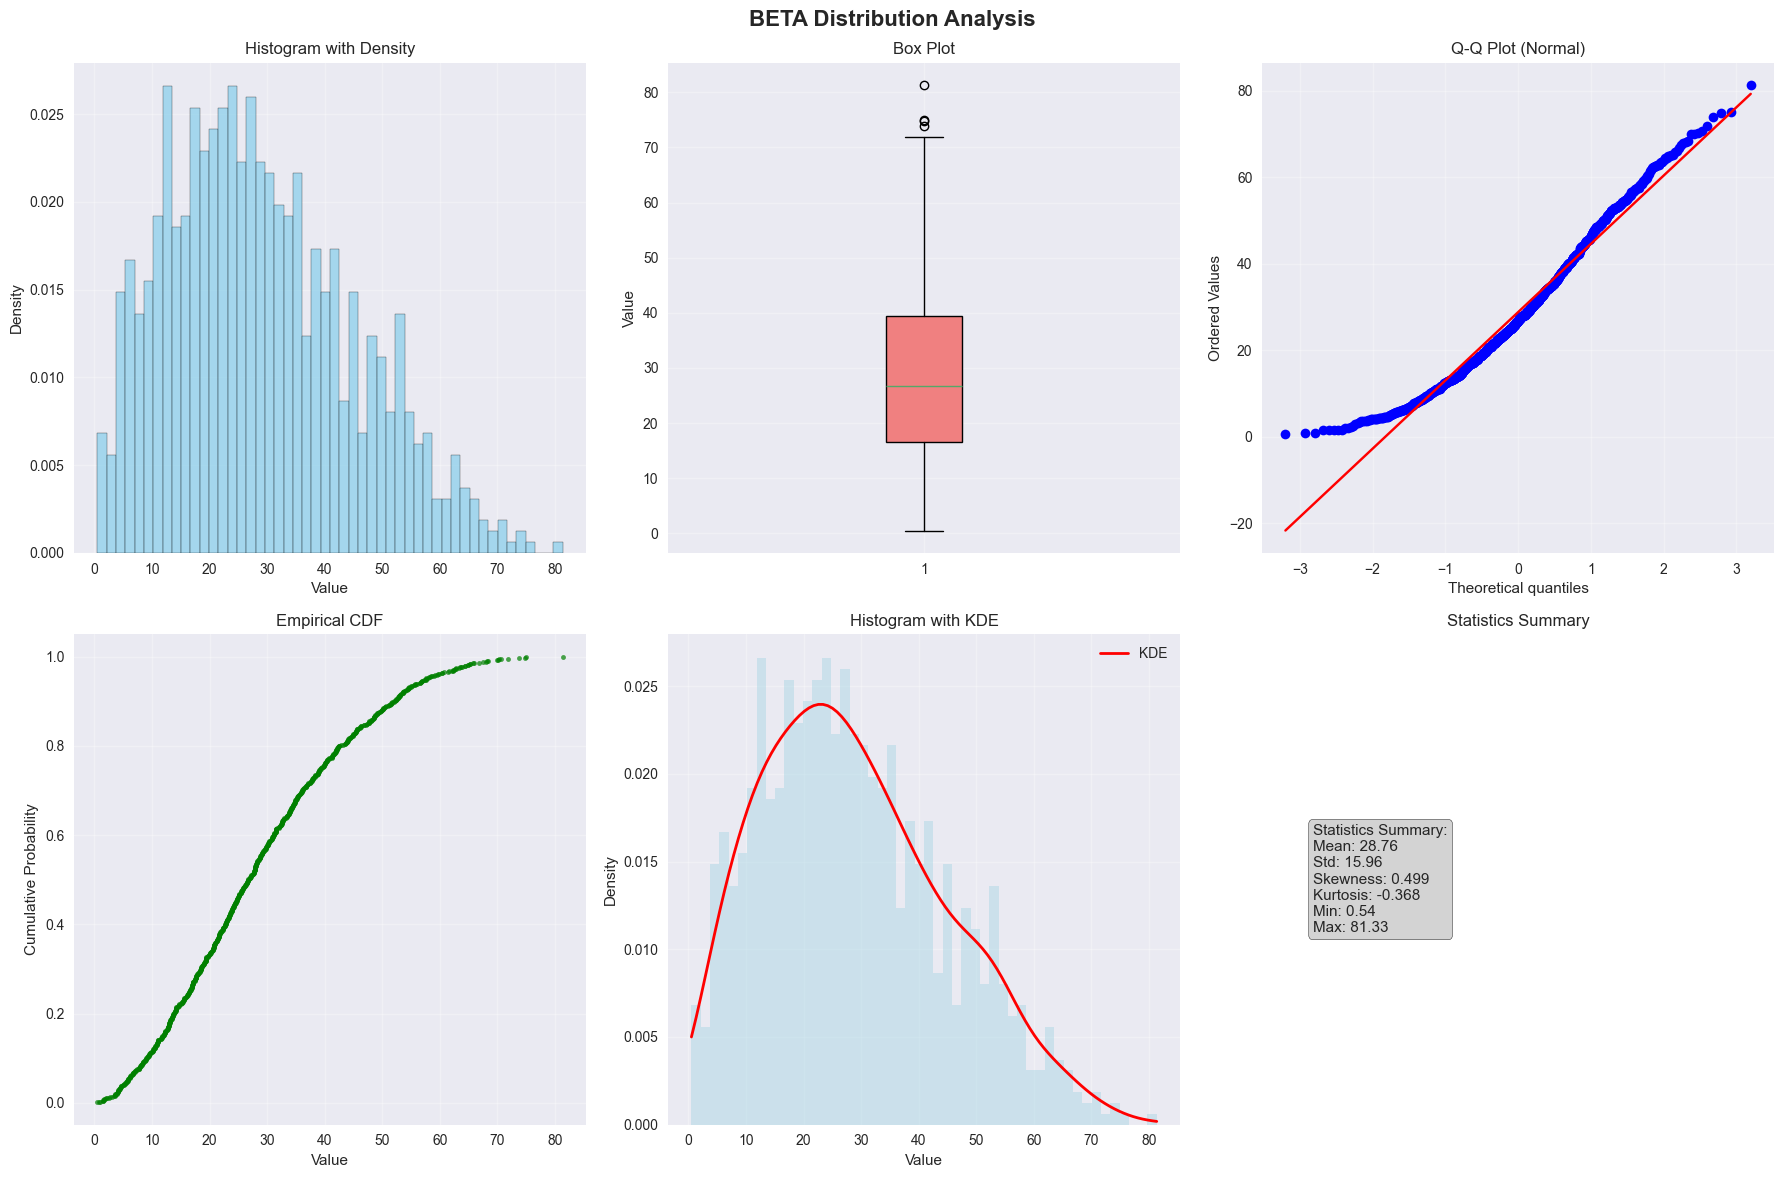


📊 EXPONENTIAL 분포 분석
----------------------------------------
Mean: 23.653
Std: 23.558
Min: 0.006
Max: 170.418
Skewness: 1.901
  → Right-skewed (positive skew)
Kurtosis: 4.805
  → Heavy tails (leptokurtic)
Shapiro-Wilk p-value: 0.000000
  → Not normal distribution (α=0.05)
Jarque-Bera p-value: 0.000000


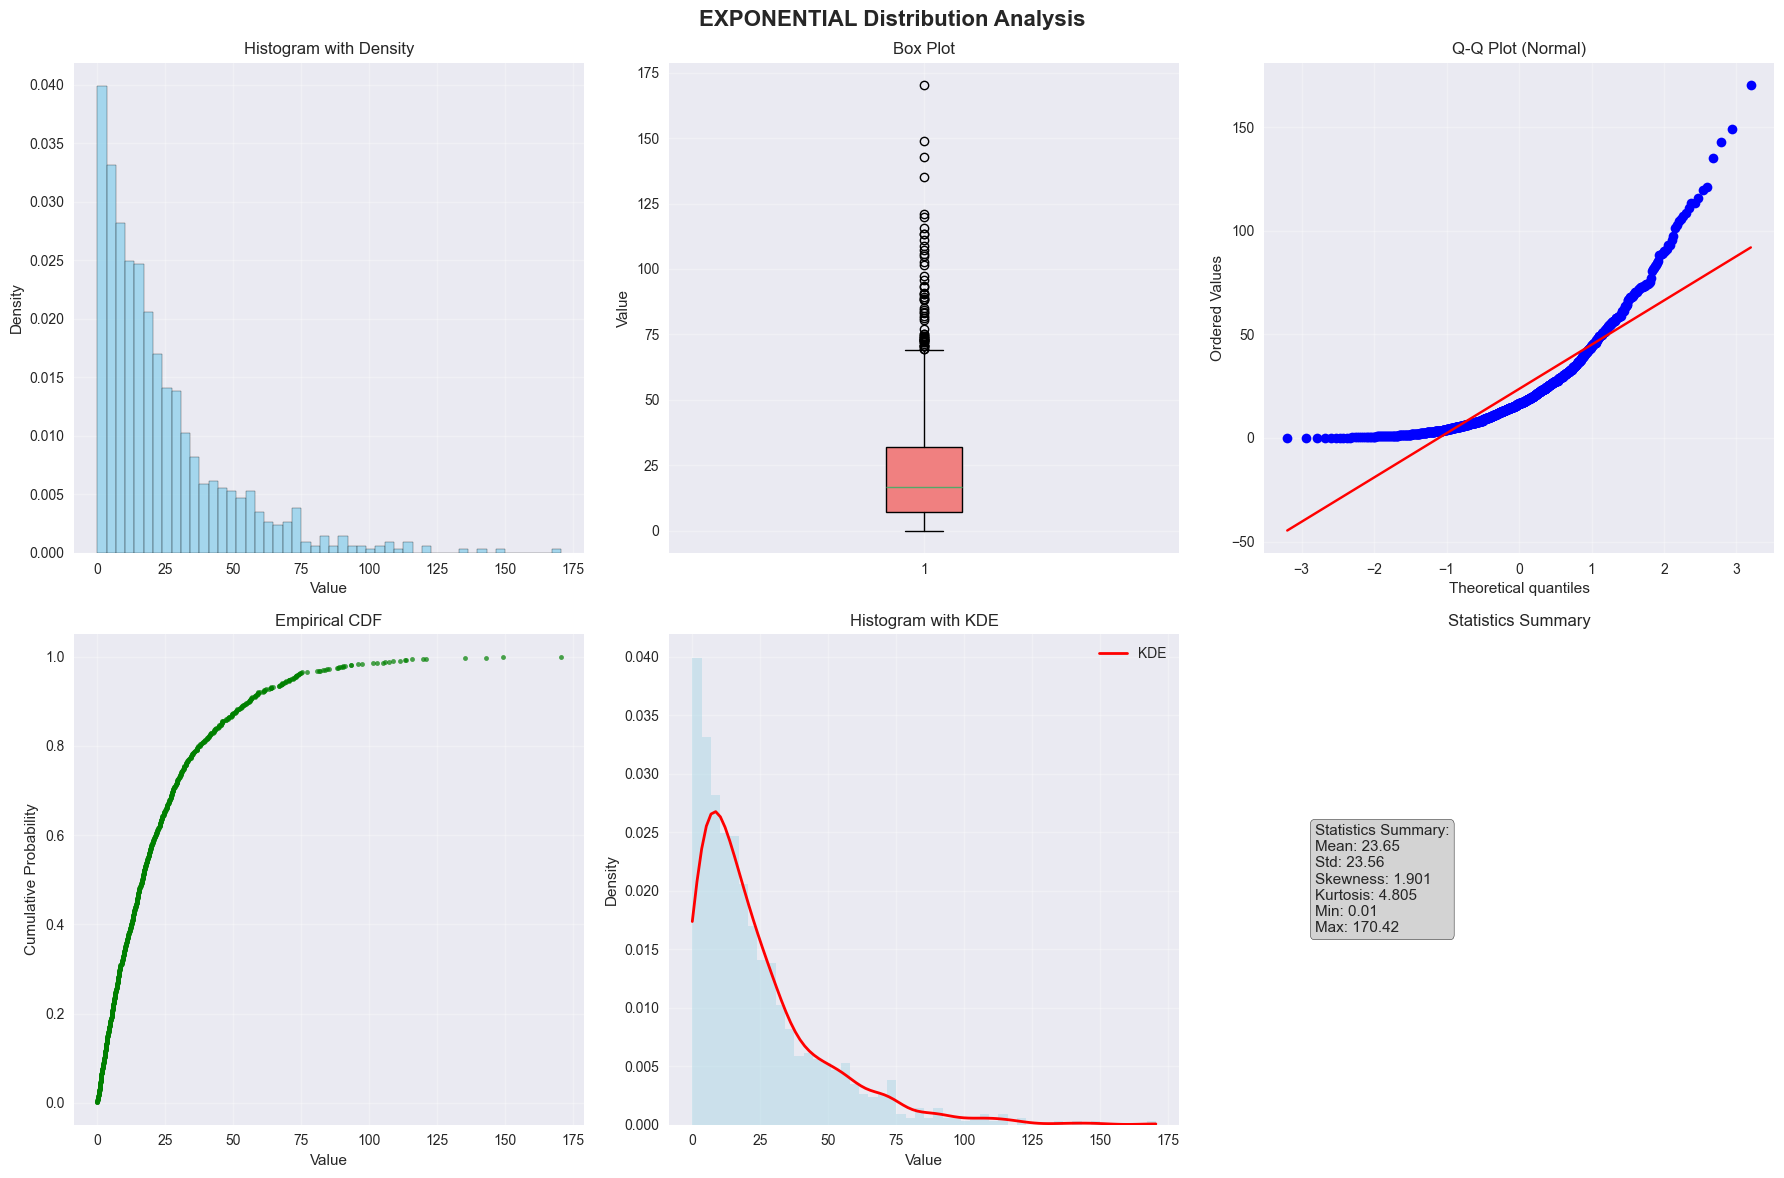


📊 GAMMA 분포 분석
----------------------------------------
Mean: 19.901
Std: 14.267
Min: 0.222
Max: 116.350
Skewness: 1.540
  → Right-skewed (positive skew)
Kurtosis: 3.975
  → Heavy tails (leptokurtic)
Shapiro-Wilk p-value: 0.000000
  → Not normal distribution (α=0.05)
Jarque-Bera p-value: 0.000000


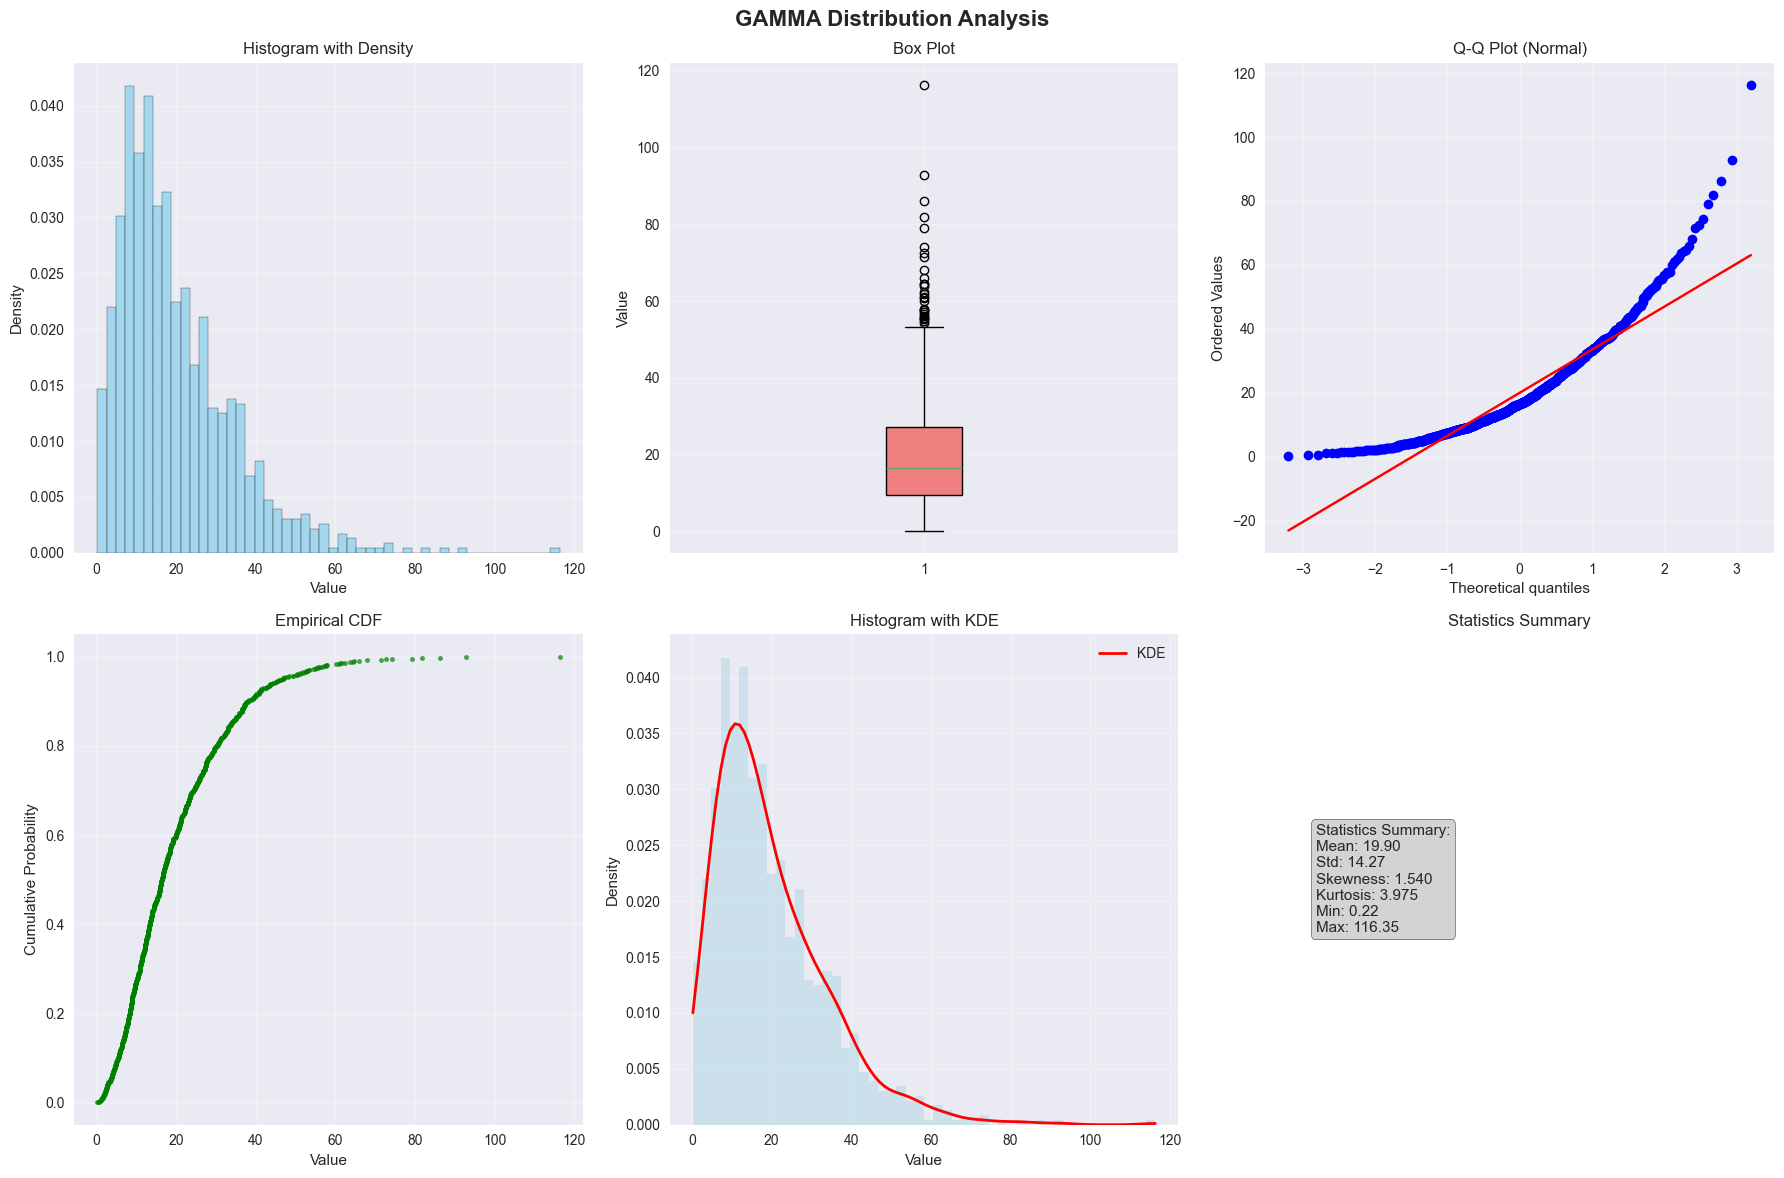


📊 BIMODAL 분포 분석
----------------------------------------
Mean: 50.271
Std: 22.052
Min: 6.455
Max: 96.891
Skewness: 0.151
  → Approximately symmetric
Kurtosis: -1.322
  → Light tails (platykurtic)
Shapiro-Wilk p-value: 0.000000
  → Not normal distribution (α=0.05)
Jarque-Bera p-value: 0.000000


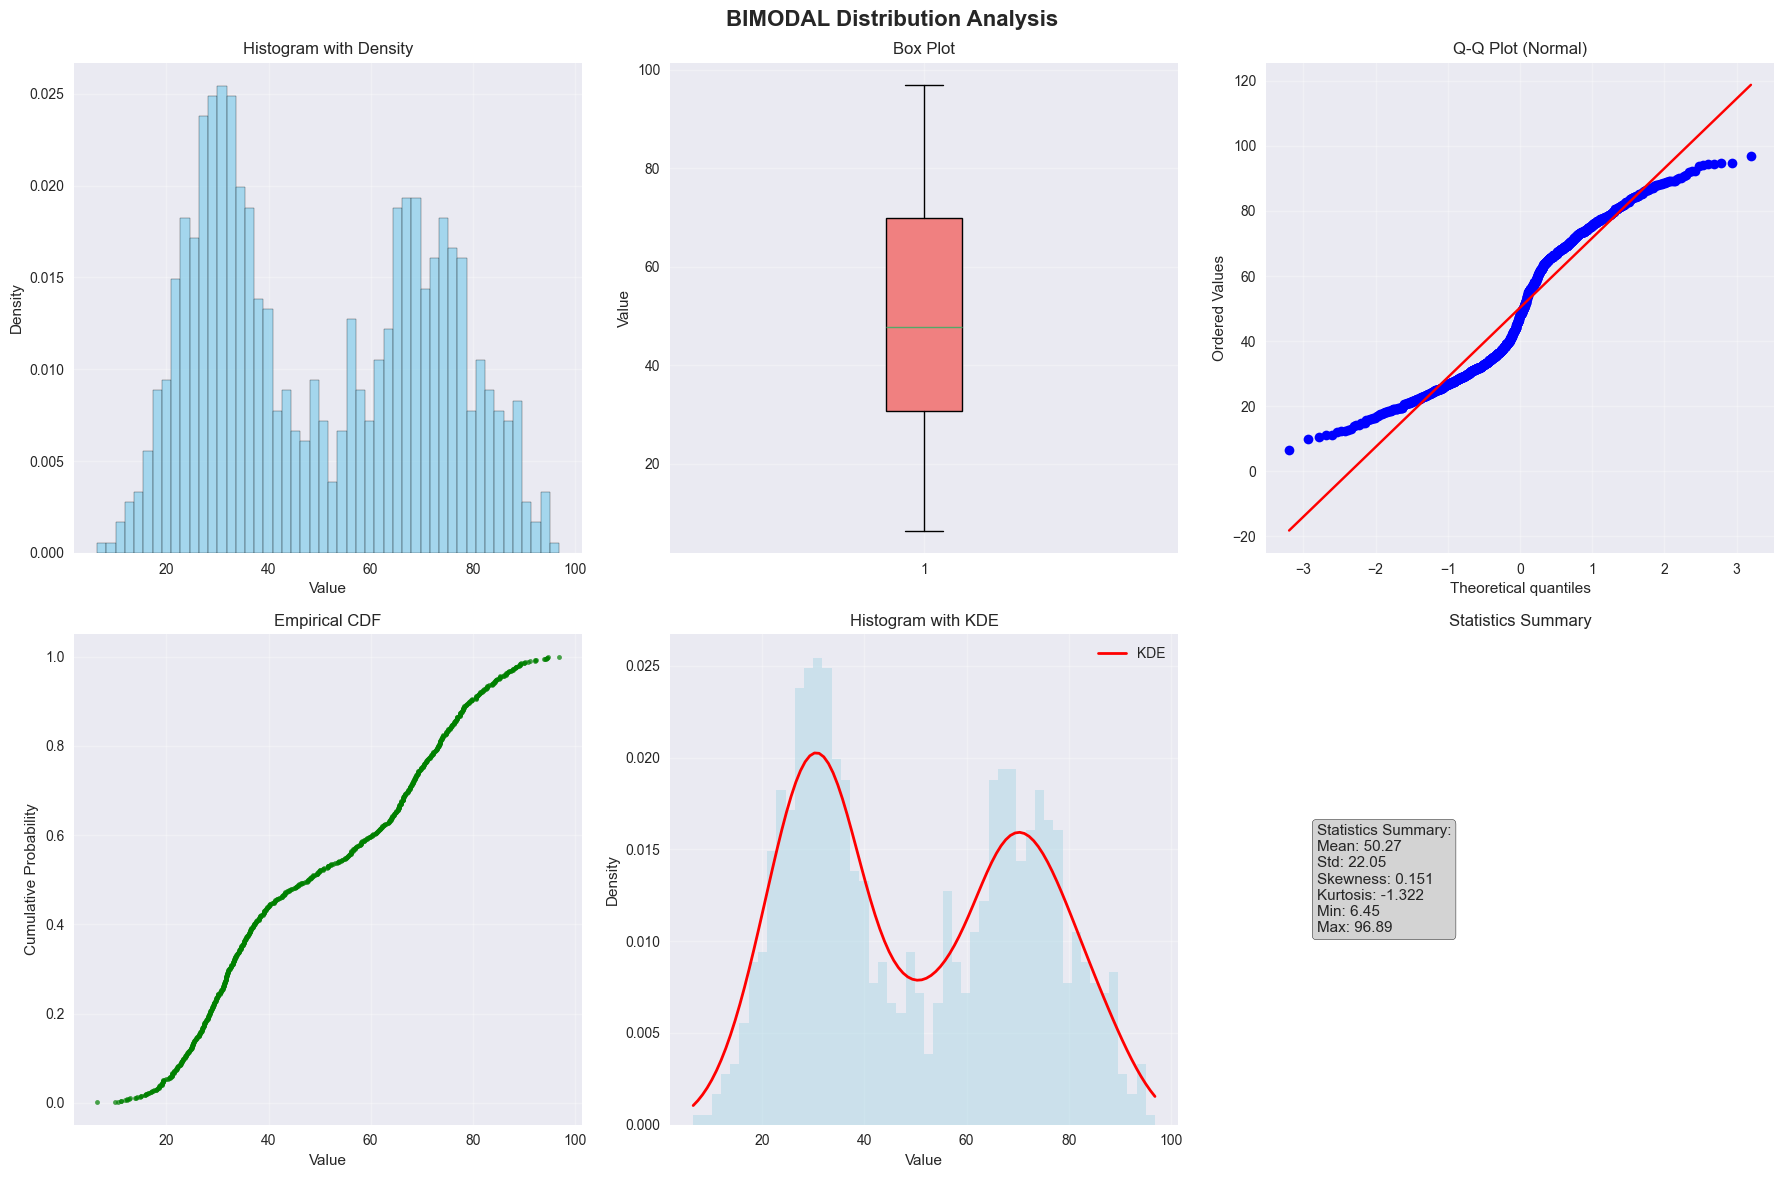


📊 WITH_OUTLIERS 분포 분석
----------------------------------------
Mean: 59.753
Std: 31.480
Min: 10.776
Max: 164.571
Skewness: 2.263
  → Right-skewed (positive skew)
Kurtosis: 3.959
  → Heavy tails (leptokurtic)
Shapiro-Wilk p-value: 0.000000
  → Not normal distribution (α=0.05)
Jarque-Bera p-value: 0.000000


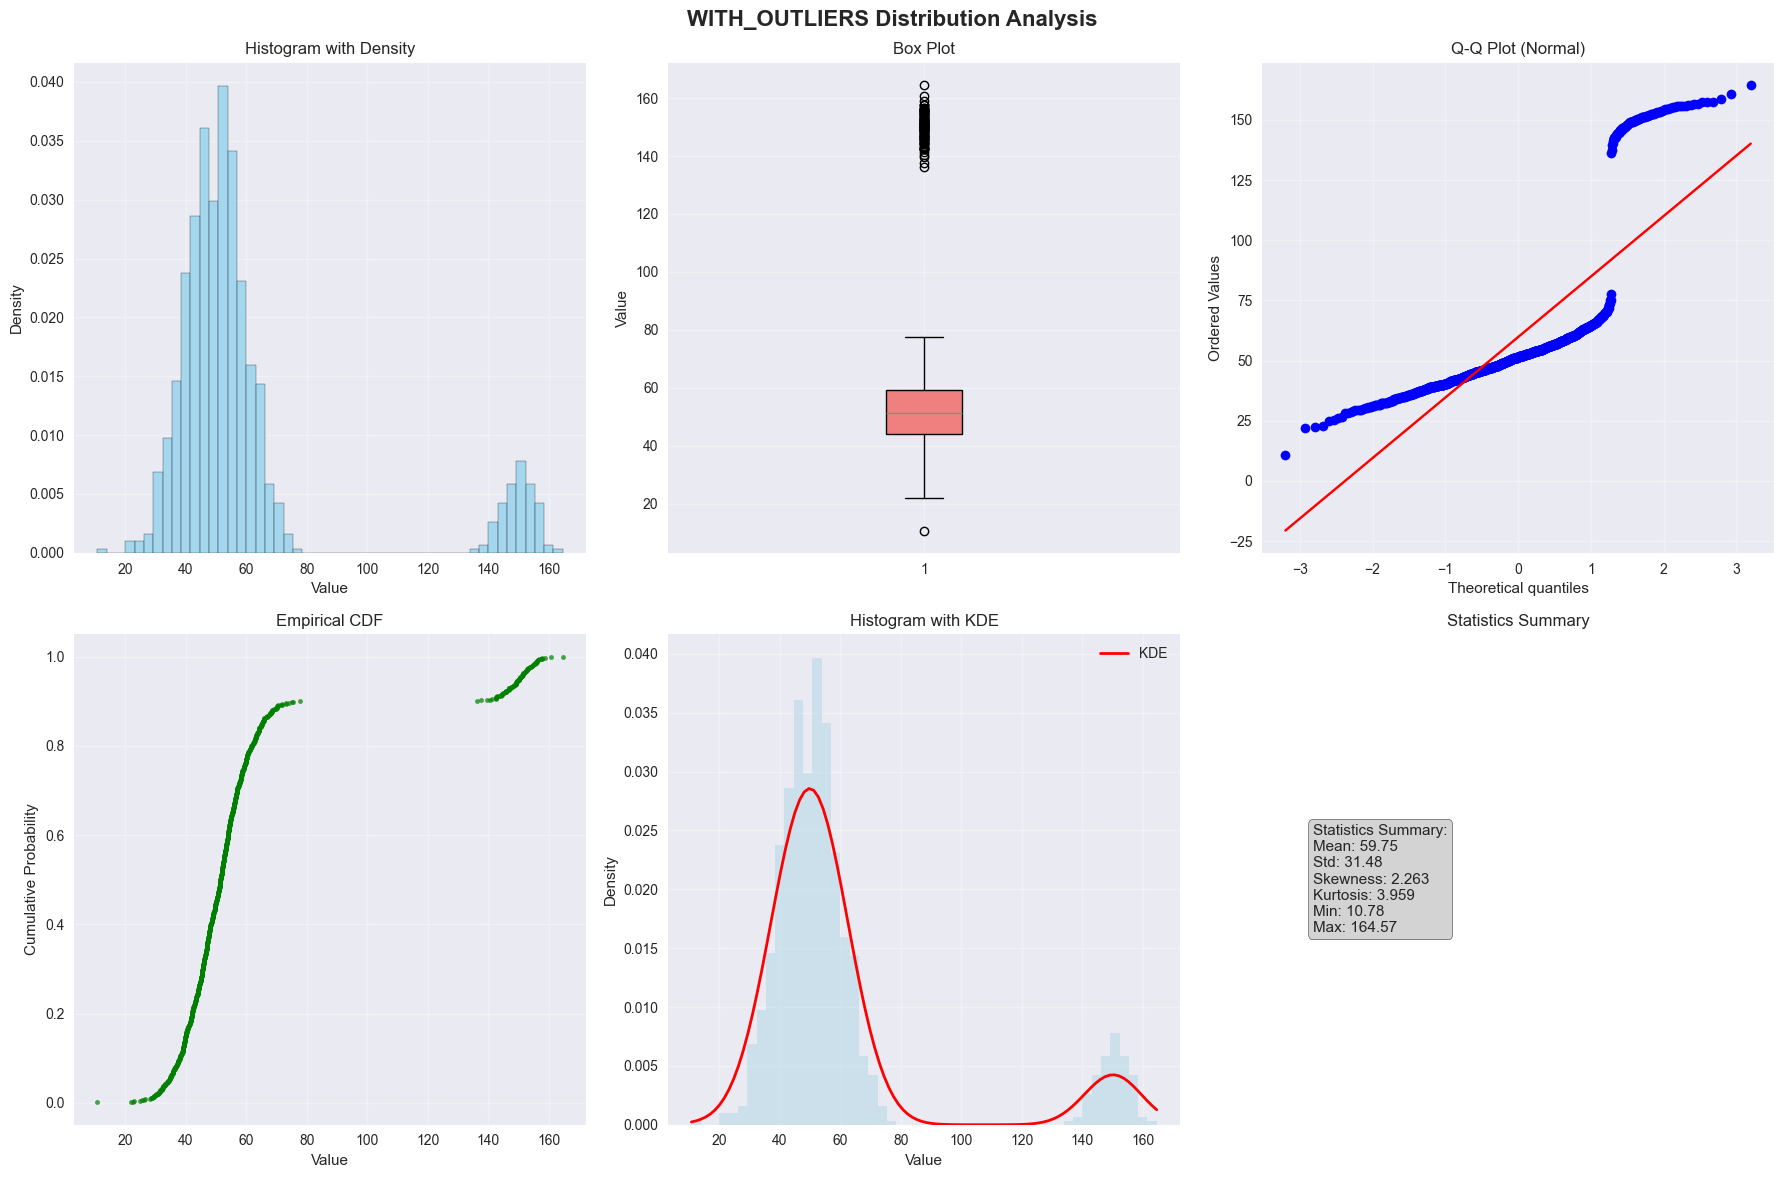

In [6]:
# 실습 1 실행
print("\n🎯 실습 1: 다양한 분포 데이터 생성 및 분석")
datasets = generate_diverse_datasets()

# 각 분포별 분석
distribution_stats = {}
for name, data in datasets.items():
    distribution_stats[name] = analyze_distribution(data, name)
    visualize_distribution(data, name)

실습 2: 전처리 방법별 효과 비교 및 최적화

In [7]:
def compare_preprocessing_methods(data, name):
    """전처리 방법별 정규성 개선 효과 비교"""
    print(f"\n🔧 {name.upper()} - 전처리 방법 비교")
    print("-" * 50)
    
    methods = {}
    results = {}
    
    # 원본 데이터
    methods['Original'] = data.copy()
    
    # 1. StandardScaler (Z-score normalization)
    scaler = StandardScaler()
    methods['StandardScaler'] = scaler.fit_transform(data.reshape(-1, 1)).flatten()
    
    # 2. MinMaxScaler
    minmax = MinMaxScaler()
    methods['MinMaxScaler'] = minmax.fit_transform(data.reshape(-1, 1)).flatten()
    
    # 3. RobustScaler (Median and IQR based)
    robust = RobustScaler()
    methods['RobustScaler'] = robust.fit_transform(data.reshape(-1, 1)).flatten()
    
    # 4. Box-Cox Transform (for positive data only)
    if np.all(data > 0):
        try:
            pt_box = PowerTransformer(method='box-cox', standardize=True)
            methods['BoxCox'] = pt_box.fit_transform(data.reshape(-1, 1)).flatten()
        except:
            print("Box-Cox transformation failed for this data")
    
    # 5. Yeo-Johnson Transform (handles negative values)
    try:
        pt_yj = PowerTransformer(method='yeo-johnson', standardize=True)
        methods['YeoJohnson'] = pt_yj.fit_transform(data.reshape(-1, 1)).flatten()
    except:
        print("Yeo-Johnson transformation failed for this data")
    
    # 6. Log Transform (for positive data only)
    if np.all(data > 0):
        try:
            log_data = np.log(data + 1e-8)  # Add small constant to avoid log(0)
            log_scaler = StandardScaler()
            methods['LogTransform'] = log_scaler.fit_transform(log_data.reshape(-1, 1)).flatten()
        except:
            print("Log transformation failed for this data")
    
    # 7. Square Root Transform
    if np.all(data >= 0):
        try:
            sqrt_data = np.sqrt(data)
            sqrt_scaler = StandardScaler()
            methods['SqrtTransform'] = sqrt_scaler.fit_transform(sqrt_data.reshape(-1, 1)).flatten()
        except:
            print("Square root transformation failed for this data")
    
    # 각 방법의 정규성 평가
    for method_name, transformed_data in methods.items():
        try:
            # 정규성 검정
            if len(transformed_data) <= 5000:
                shapiro_stat, shapiro_p = shapiro(transformed_data)
            else:
                shapiro_p = None
                
            jb_stat, jb_p = jarque_bera(transformed_data)
            skewness = stats.skew(transformed_data)
            kurtosis = stats.kurtosis(transformed_data)
            
            results[method_name] = {
                'shapiro_p': shapiro_p,
                'jb_p': jb_p,
                'skewness': skewness,
                'kurtosis': kurtosis,
                'abs_skewness': abs(skewness),
                'abs_kurtosis': abs(kurtosis)
            }
            
            print(f"{method_name:15s}: ", end="")
            if shapiro_p is not None:
                print(f"Shapiro p={shapiro_p:.4f}, ", end="")
            print(f"JB p={jb_p:.4f}, Skew={skewness:.3f}, Kurt={kurtosis:.3f}")
            
        except Exception as e:
            print(f"{method_name}: Error - {e}")
    
    # 최적 방법 추천 (여러 기준 종합)
    if results:
        # 정규성에 가장 가까운 방법 찾기 (복합 점수)
        best_method = min(results.keys(), 
                         key=lambda x: (
                             results[x]['abs_skewness'] * 0.4 +  # 왜도 가중치
                             results[x]['abs_kurtosis'] * 0.3 +   # 첨도 가중치
                             (1 - results[x]['jb_p']) * 0.3       # JB 검정 가중치
                         ))
        
        print(f"\n🏆 권장 전처리 방법: {best_method}")
        print(f"   - Skewness improvement: {results['Original']['abs_skewness']:.3f} → {results[best_method]['abs_skewness']:.3f}")
        print(f"   - Kurtosis improvement: {results['Original']['abs_kurtosis']:.3f} → {results[best_method]['abs_kurtosis']:.3f}")
        
        return methods, results, best_method
    
    return methods, results, None

In [8]:
def visualize_preprocessing_comparison(methods, name):
    """전처리 방법별 결과 시각화"""
    n_methods = len(methods)
    n_cols = 3
    n_rows = (n_methods + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'{name.upper()} - Preprocessing Methods Comparison', fontsize=16)
    
    for idx, (method_name, data) in enumerate(methods.items()):
        row = idx // n_cols
        col = idx % n_cols
        
        if n_rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col]
        
        # 히스토그램과 Q-Q plot을 subplot으로
        ax.hist(data, bins=30, alpha=0.7, density=True, color=f'C{idx}')
        ax.set_title(f'{method_name}\nSkew: {stats.skew(data):.3f}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
    
    # 빈 subplot 제거
    for idx in range(len(methods), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        if n_rows > 1:
            fig.delaxes(axes[row, col])
        else:
            if col < len(axes):
                fig.delaxes(axes[col])
    
    plt.tight_layout()
    plt.show()


🎯 실습 2: 전처리 방법별 효과 비교

🔧 NORMAL - 전처리 방법 비교
--------------------------------------------------
Original       : Shapiro p=0.6273, JB p=0.2928, Skew=0.117, Kurt=0.066
StandardScaler : Shapiro p=0.6273, JB p=0.2928, Skew=0.117, Kurt=0.066
MinMaxScaler   : Shapiro p=0.6273, JB p=0.2928, Skew=0.117, Kurt=0.066
RobustScaler   : Shapiro p=0.6273, JB p=0.2928, Skew=0.117, Kurt=0.066
BoxCox         : Shapiro p=0.9751, JB p=0.8288, Skew=0.009, Kurt=0.093
YeoJohnson     : Shapiro p=0.9764, JB p=0.8373, Skew=0.009, Kurt=0.090
LogTransform   : Shapiro p=0.0000, JB p=0.0000, Skew=-1.896, Kurt=12.518
SqrtTransform  : Shapiro p=0.0000, JB p=0.0000, Skew=-0.466, Kurt=0.947

🏆 권장 전처리 방법: YeoJohnson
   - Skewness improvement: 0.117 → 0.009
   - Kurtosis improvement: 0.066 → 0.090


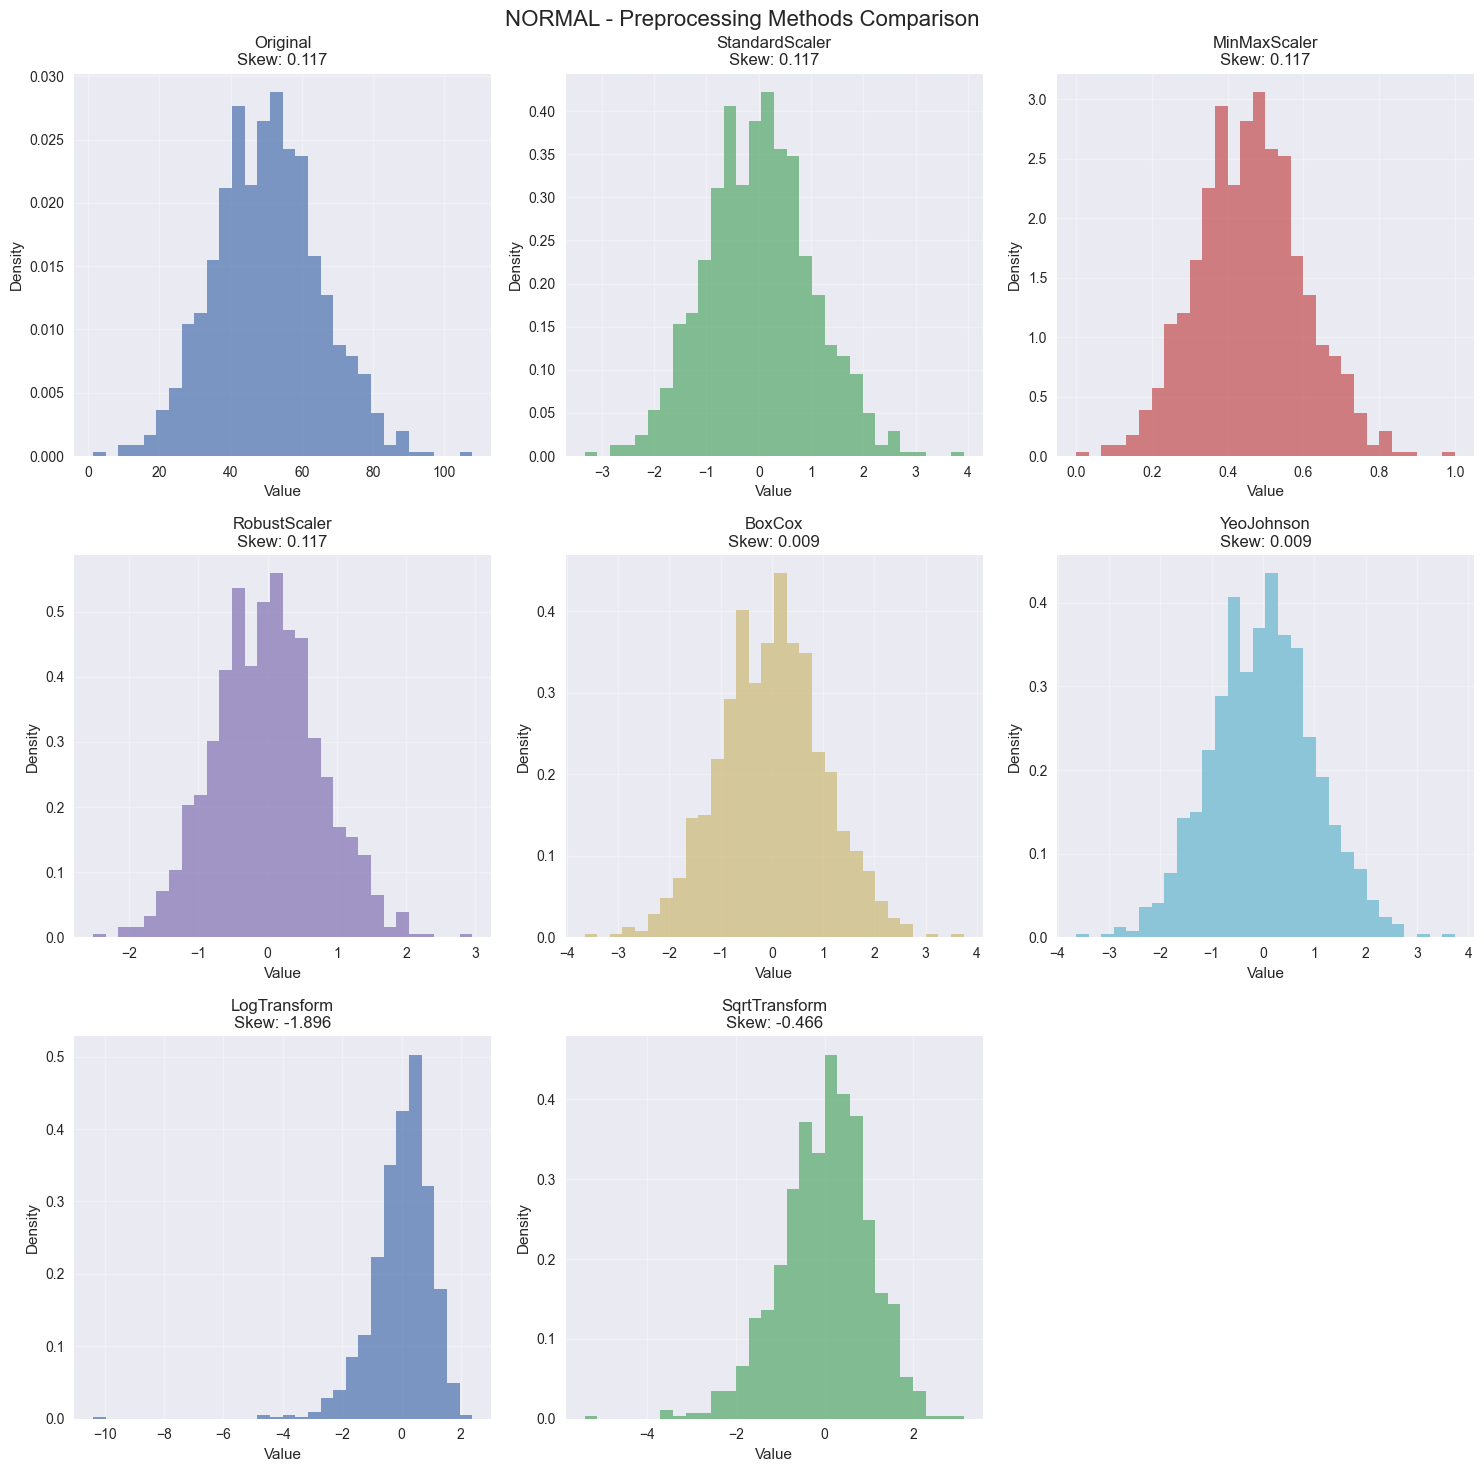


🔧 LOGNORMAL - 전처리 방법 비교
--------------------------------------------------
Original       : Shapiro p=0.0000, JB p=0.0000, Skew=2.903, Kurt=13.869
StandardScaler : Shapiro p=0.0000, JB p=0.0000, Skew=2.903, Kurt=13.869
MinMaxScaler   : Shapiro p=0.0000, JB p=0.0000, Skew=2.903, Kurt=13.869
RobustScaler   : Shapiro p=0.0000, JB p=0.0000, Skew=2.903, Kurt=13.869
BoxCox         : Shapiro p=0.8274, JB p=0.9622, Skew=0.000, Kurt=0.043
YeoJohnson     : Shapiro p=0.8671, JB p=0.8841, Skew=0.001, Kurt=-0.077
LogTransform   : Shapiro p=0.7312, JB p=0.7716, Skew=-0.049, Kurt=0.052
SqrtTransform  : Shapiro p=0.0000, JB p=0.0000, Skew=1.212, Kurt=2.353

🏆 권장 전처리 방법: BoxCox
   - Skewness improvement: 2.903 → 0.000
   - Kurtosis improvement: 13.869 → 0.043


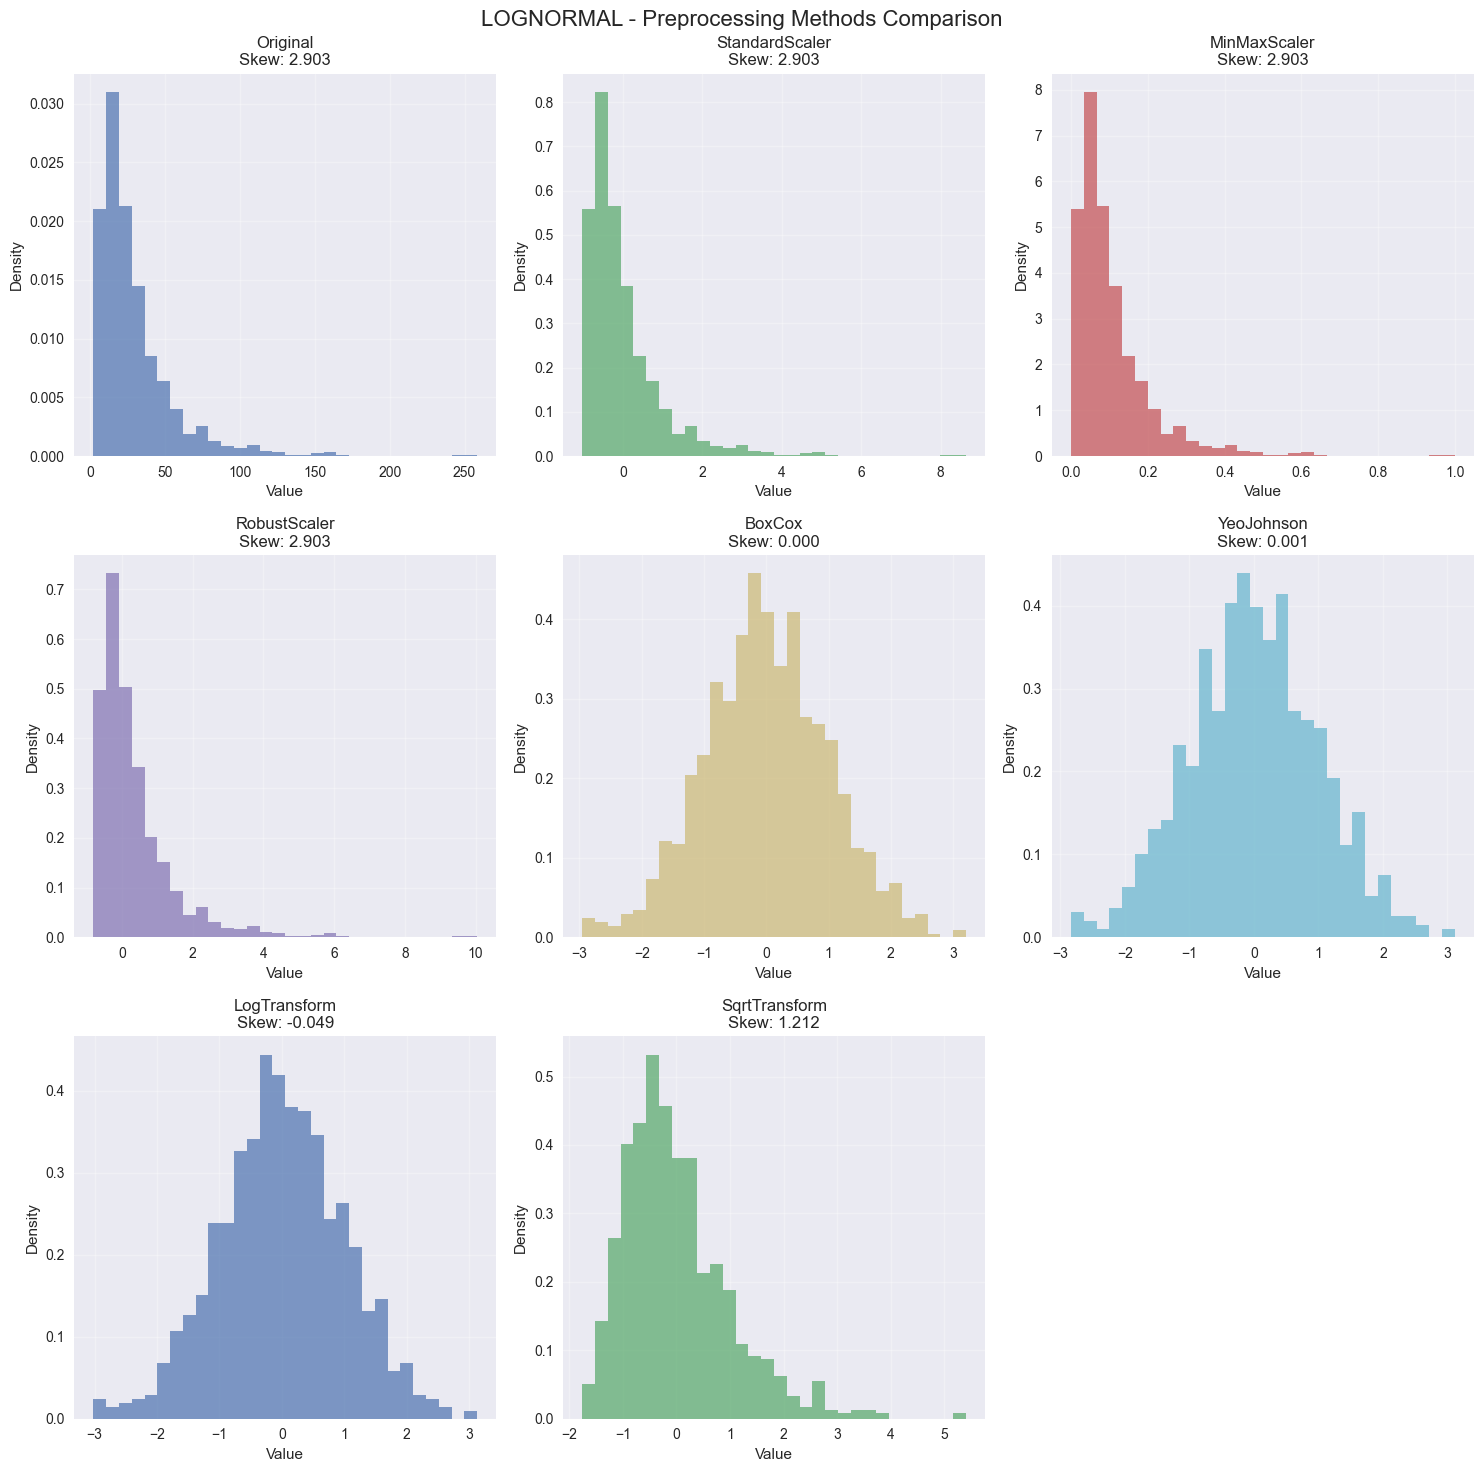


🔧 BETA - 전처리 방법 비교
--------------------------------------------------
Original       : Shapiro p=0.0000, JB p=0.0000, Skew=0.499, Kurt=-0.368
StandardScaler : Shapiro p=0.0000, JB p=0.0000, Skew=0.499, Kurt=-0.368
MinMaxScaler   : Shapiro p=0.0000, JB p=0.0000, Skew=0.499, Kurt=-0.368
RobustScaler   : Shapiro p=0.0000, JB p=0.0000, Skew=0.499, Kurt=-0.368
BoxCox         : Shapiro p=0.0005, JB p=0.0016, Skew=-0.079, Kurt=-0.533
YeoJohnson     : Shapiro p=0.0002, JB p=0.0009, Skew=-0.071, Kurt=-0.561
LogTransform   : Shapiro p=0.0000, JB p=0.0000, Skew=-1.227, Kurt=2.287
SqrtTransform  : Shapiro p=0.0002, JB p=0.0010, Skew=-0.163, Kurt=-0.474

🏆 권장 전처리 방법: BoxCox
   - Skewness improvement: 0.499 → 0.079
   - Kurtosis improvement: 0.368 → 0.533


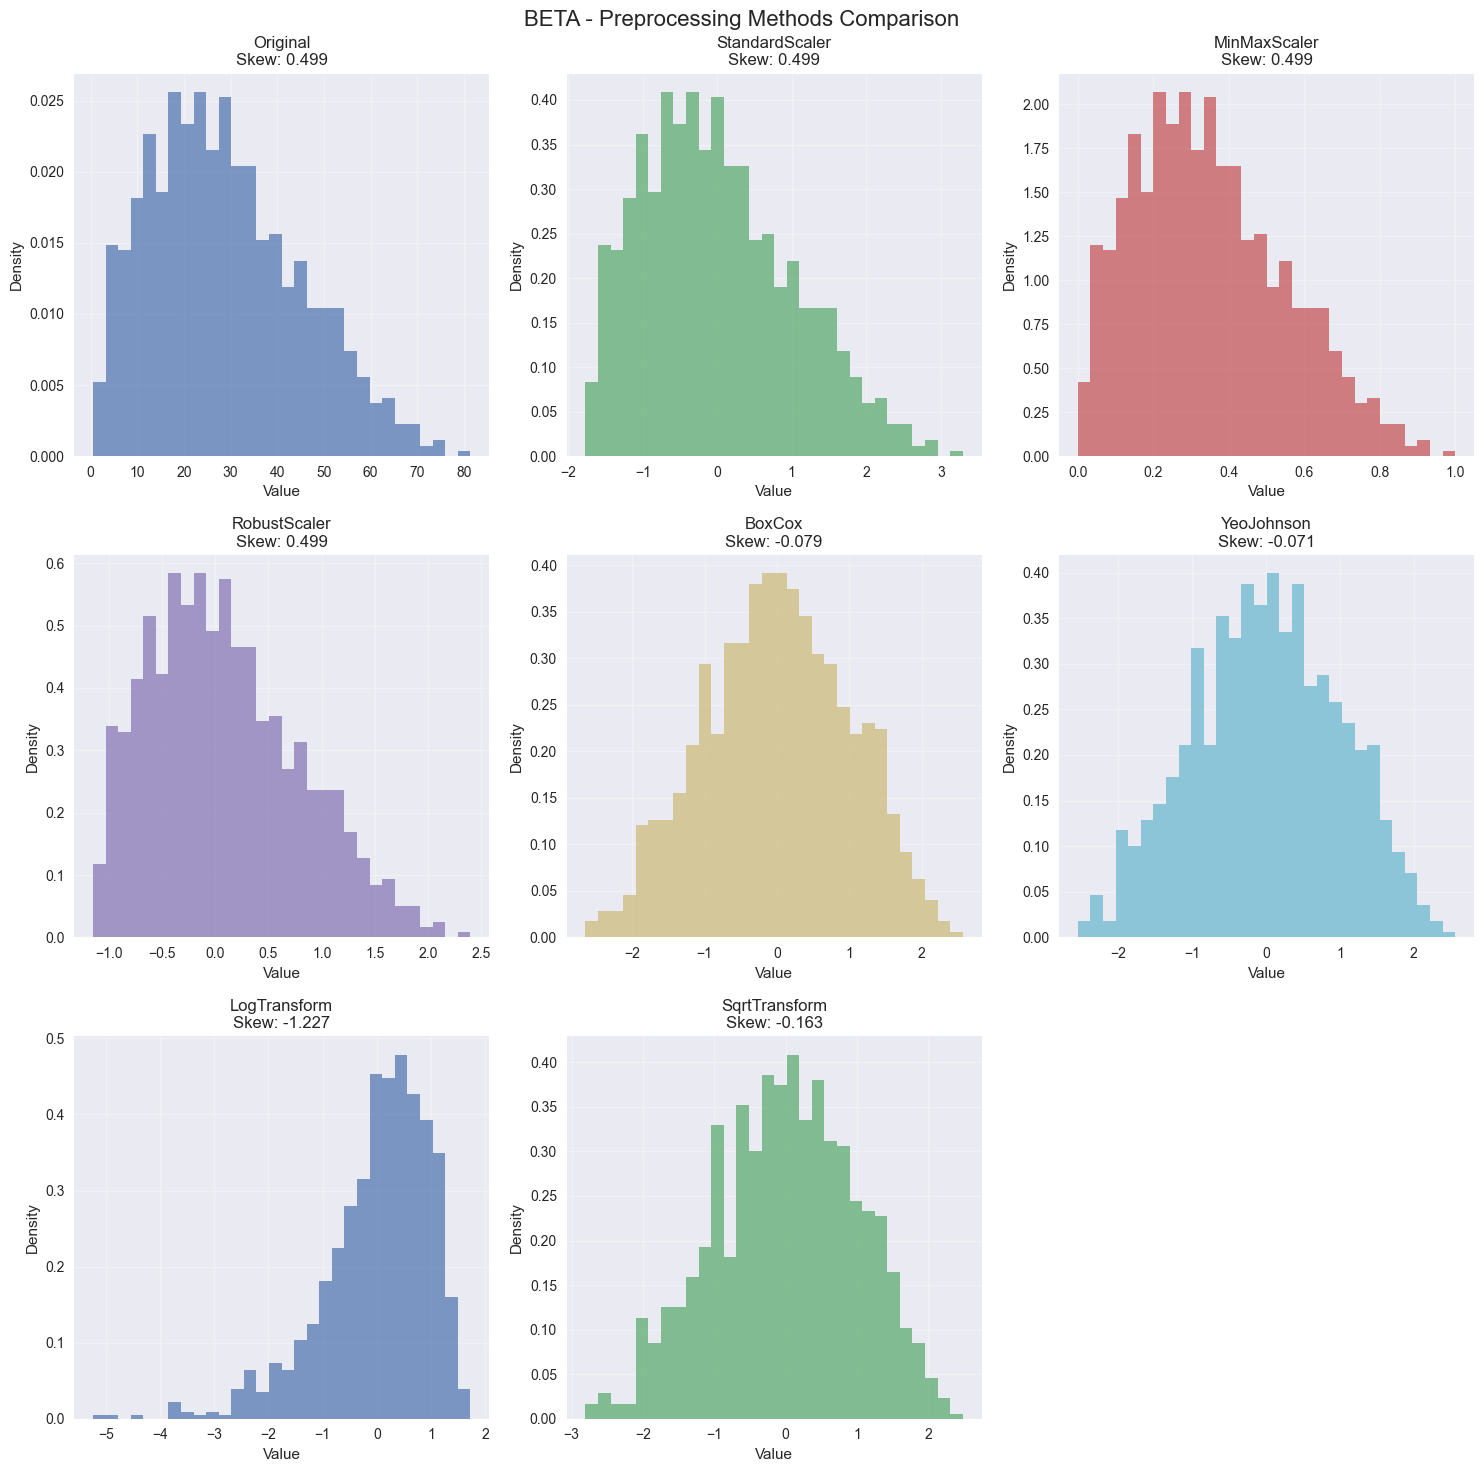


🔧 EXPONENTIAL - 전처리 방법 비교
--------------------------------------------------
Original       : Shapiro p=0.0000, JB p=0.0000, Skew=1.901, Kurt=4.805
StandardScaler : Shapiro p=0.0000, JB p=0.0000, Skew=1.901, Kurt=4.805
MinMaxScaler   : Shapiro p=0.0000, JB p=0.0000, Skew=1.901, Kurt=4.805
RobustScaler   : Shapiro p=0.0000, JB p=0.0000, Skew=1.901, Kurt=4.805
BoxCox         : Shapiro p=0.5595, JB p=0.2957, Skew=-0.031, Kurt=-0.234
YeoJohnson     : Shapiro p=0.0002, JB p=0.0023, Skew=-0.031, Kurt=-0.536
LogTransform   : Shapiro p=0.0000, JB p=0.0000, Skew=-1.332, Kurt=3.744
SqrtTransform  : Shapiro p=0.0000, JB p=0.0000, Skew=0.631, Kurt=0.180

🏆 권장 전처리 방법: BoxCox
   - Skewness improvement: 1.901 → 0.031
   - Kurtosis improvement: 4.805 → 0.234


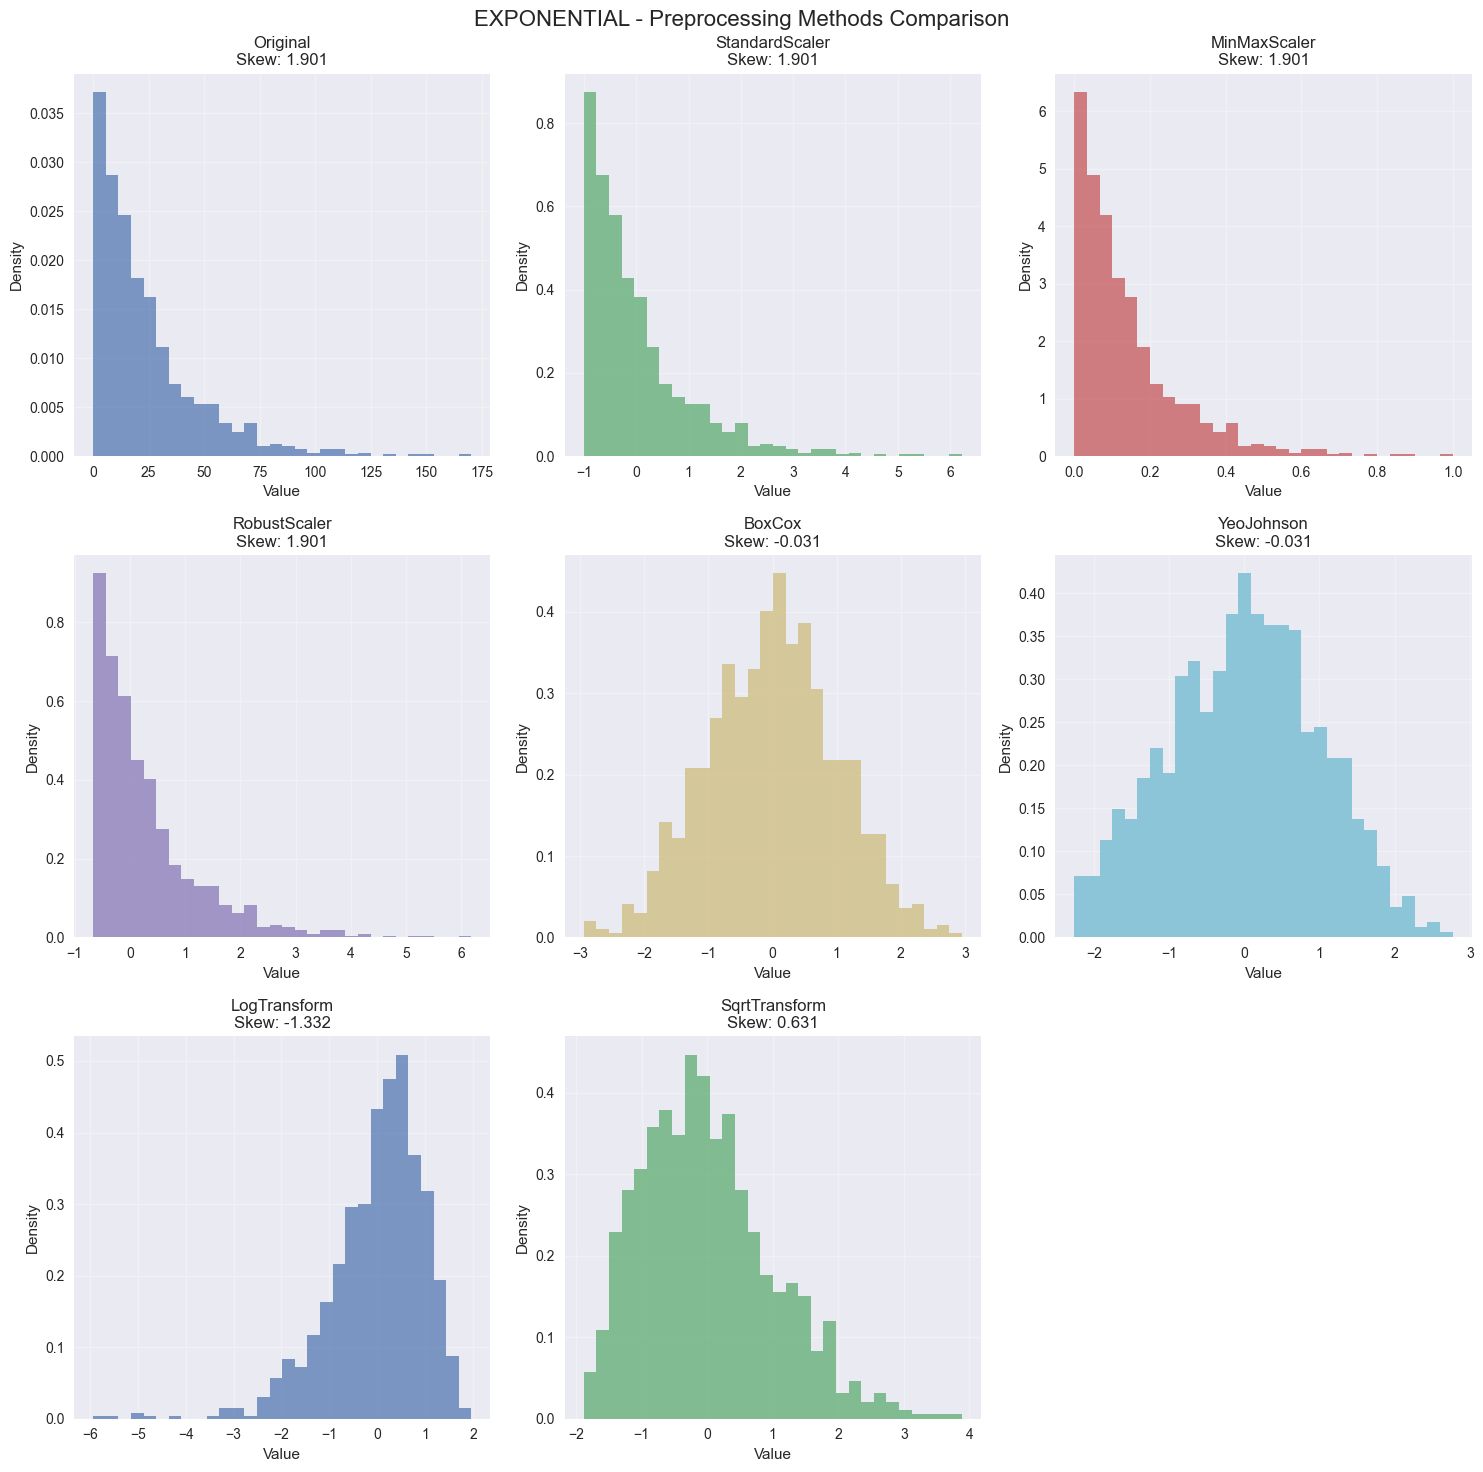


🔧 GAMMA - 전처리 방법 비교
--------------------------------------------------
Original       : Shapiro p=0.0000, JB p=0.0000, Skew=1.540, Kurt=3.975
StandardScaler : Shapiro p=0.0000, JB p=0.0000, Skew=1.540, Kurt=3.975
MinMaxScaler   : Shapiro p=0.0000, JB p=0.0000, Skew=1.540, Kurt=3.975
RobustScaler   : Shapiro p=0.0000, JB p=0.0000, Skew=1.540, Kurt=3.975
BoxCox         : Shapiro p=0.9771, JB p=0.9606, Skew=-0.005, Kurt=-0.043
YeoJohnson     : Shapiro p=0.6589, JB p=0.4921, Skew=-0.011, Kurt=-0.183
LogTransform   : Shapiro p=0.0000, JB p=0.0000, Skew=-0.813, Kurt=1.373
SqrtTransform  : Shapiro p=0.0000, JB p=0.0000, Skew=0.441, Kurt=0.210

🏆 권장 전처리 방법: BoxCox
   - Skewness improvement: 1.540 → 0.005
   - Kurtosis improvement: 3.975 → 0.043


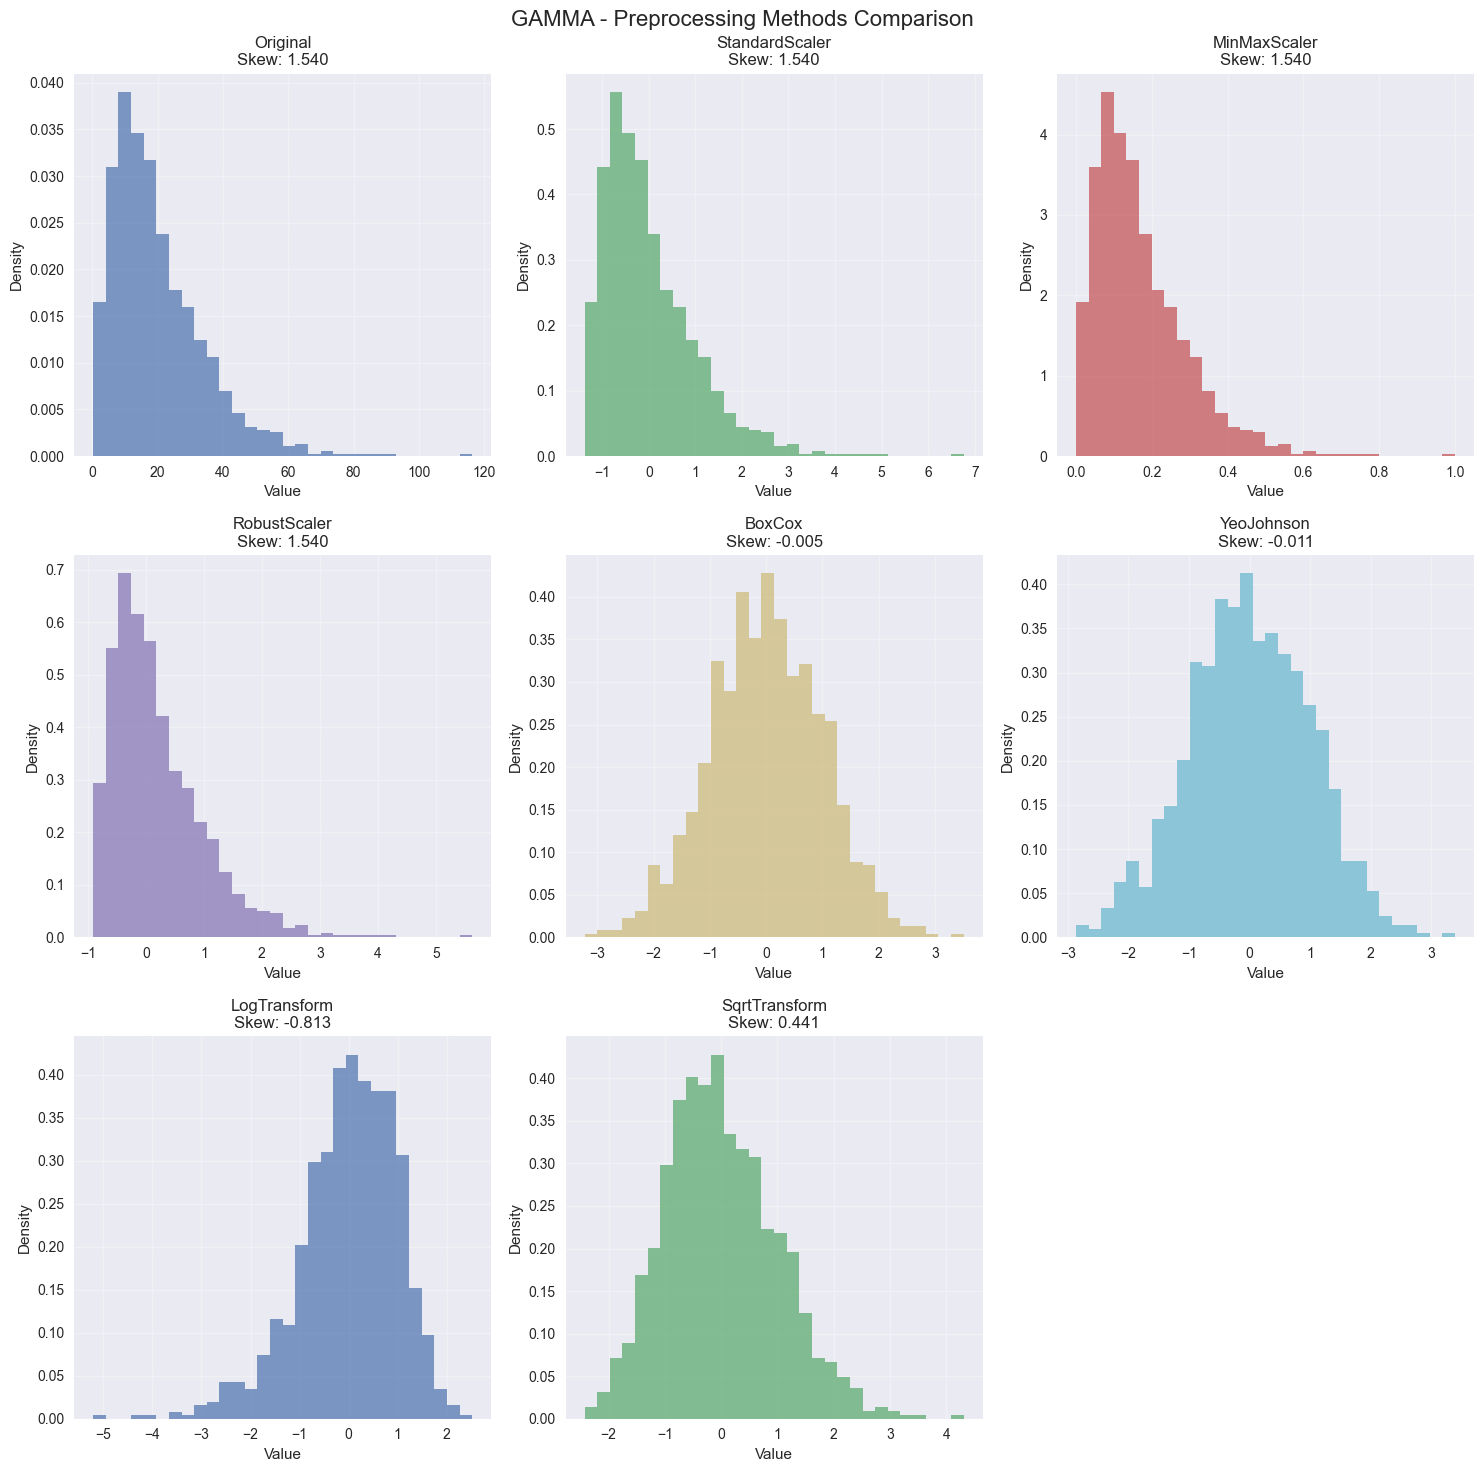


🔧 BIMODAL - 전처리 방법 비교
--------------------------------------------------
Original       : Shapiro p=0.0000, JB p=0.0000, Skew=0.151, Kurt=-1.322
StandardScaler : Shapiro p=0.0000, JB p=0.0000, Skew=0.151, Kurt=-1.322
MinMaxScaler   : Shapiro p=0.0000, JB p=0.0000, Skew=0.151, Kurt=-1.322
RobustScaler   : Shapiro p=0.0000, JB p=0.0000, Skew=0.151, Kurt=-1.322
BoxCox         : Shapiro p=0.0000, JB p=0.0000, Skew=-0.100, Kurt=-1.232
YeoJohnson     : Shapiro p=0.0000, JB p=0.0000, Skew=-0.097, Kurt=-1.238
LogTransform   : Shapiro p=0.0000, JB p=0.0000, Skew=-0.448, Kurt=-0.655
SqrtTransform  : Shapiro p=0.0000, JB p=0.0000, Skew=-0.102, Kurt=-1.230

🏆 권장 전처리 방법: LogTransform
   - Skewness improvement: 0.151 → 0.448
   - Kurtosis improvement: 1.322 → 0.655


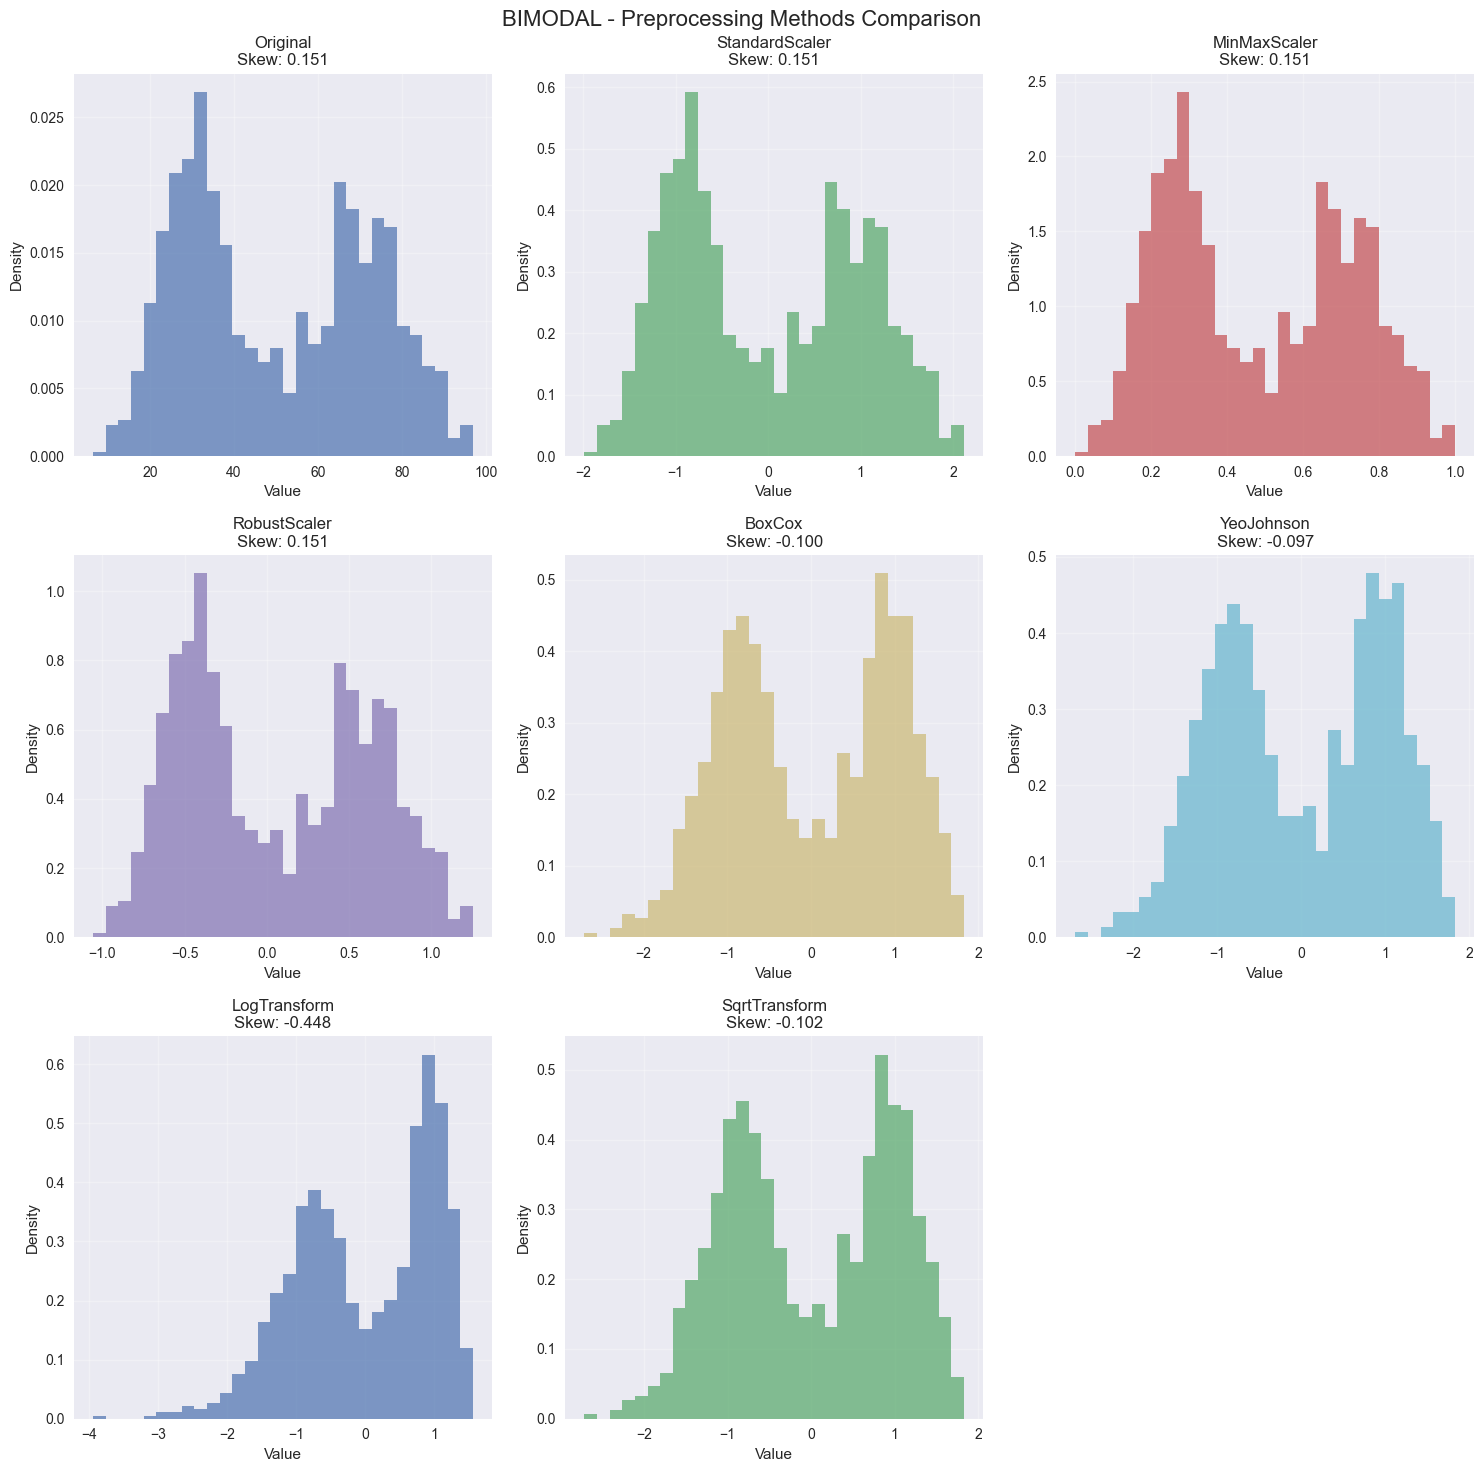


🔧 WITH_OUTLIERS - 전처리 방법 비교
--------------------------------------------------
Original       : Shapiro p=0.0000, JB p=0.0000, Skew=2.263, Kurt=3.959
StandardScaler : Shapiro p=0.0000, JB p=0.0000, Skew=2.263, Kurt=3.959
MinMaxScaler   : Shapiro p=0.0000, JB p=0.0000, Skew=2.263, Kurt=3.959
RobustScaler   : Shapiro p=0.0000, JB p=0.0000, Skew=2.263, Kurt=3.959
BoxCox         : Shapiro p=0.0000, JB p=0.0000, Skew=-0.336, Kurt=7.231
YeoJohnson     : Shapiro p=0.0000, JB p=0.0000, Skew=-0.330, Kurt=6.943
LogTransform   : Shapiro p=0.0000, JB p=0.0000, Skew=1.368, Kurt=2.233
SqrtTransform  : Shapiro p=0.0000, JB p=0.0000, Skew=1.920, Kurt=3.086

🏆 권장 전처리 방법: LogTransform
   - Skewness improvement: 2.263 → 1.368
   - Kurtosis improvement: 3.959 → 2.233


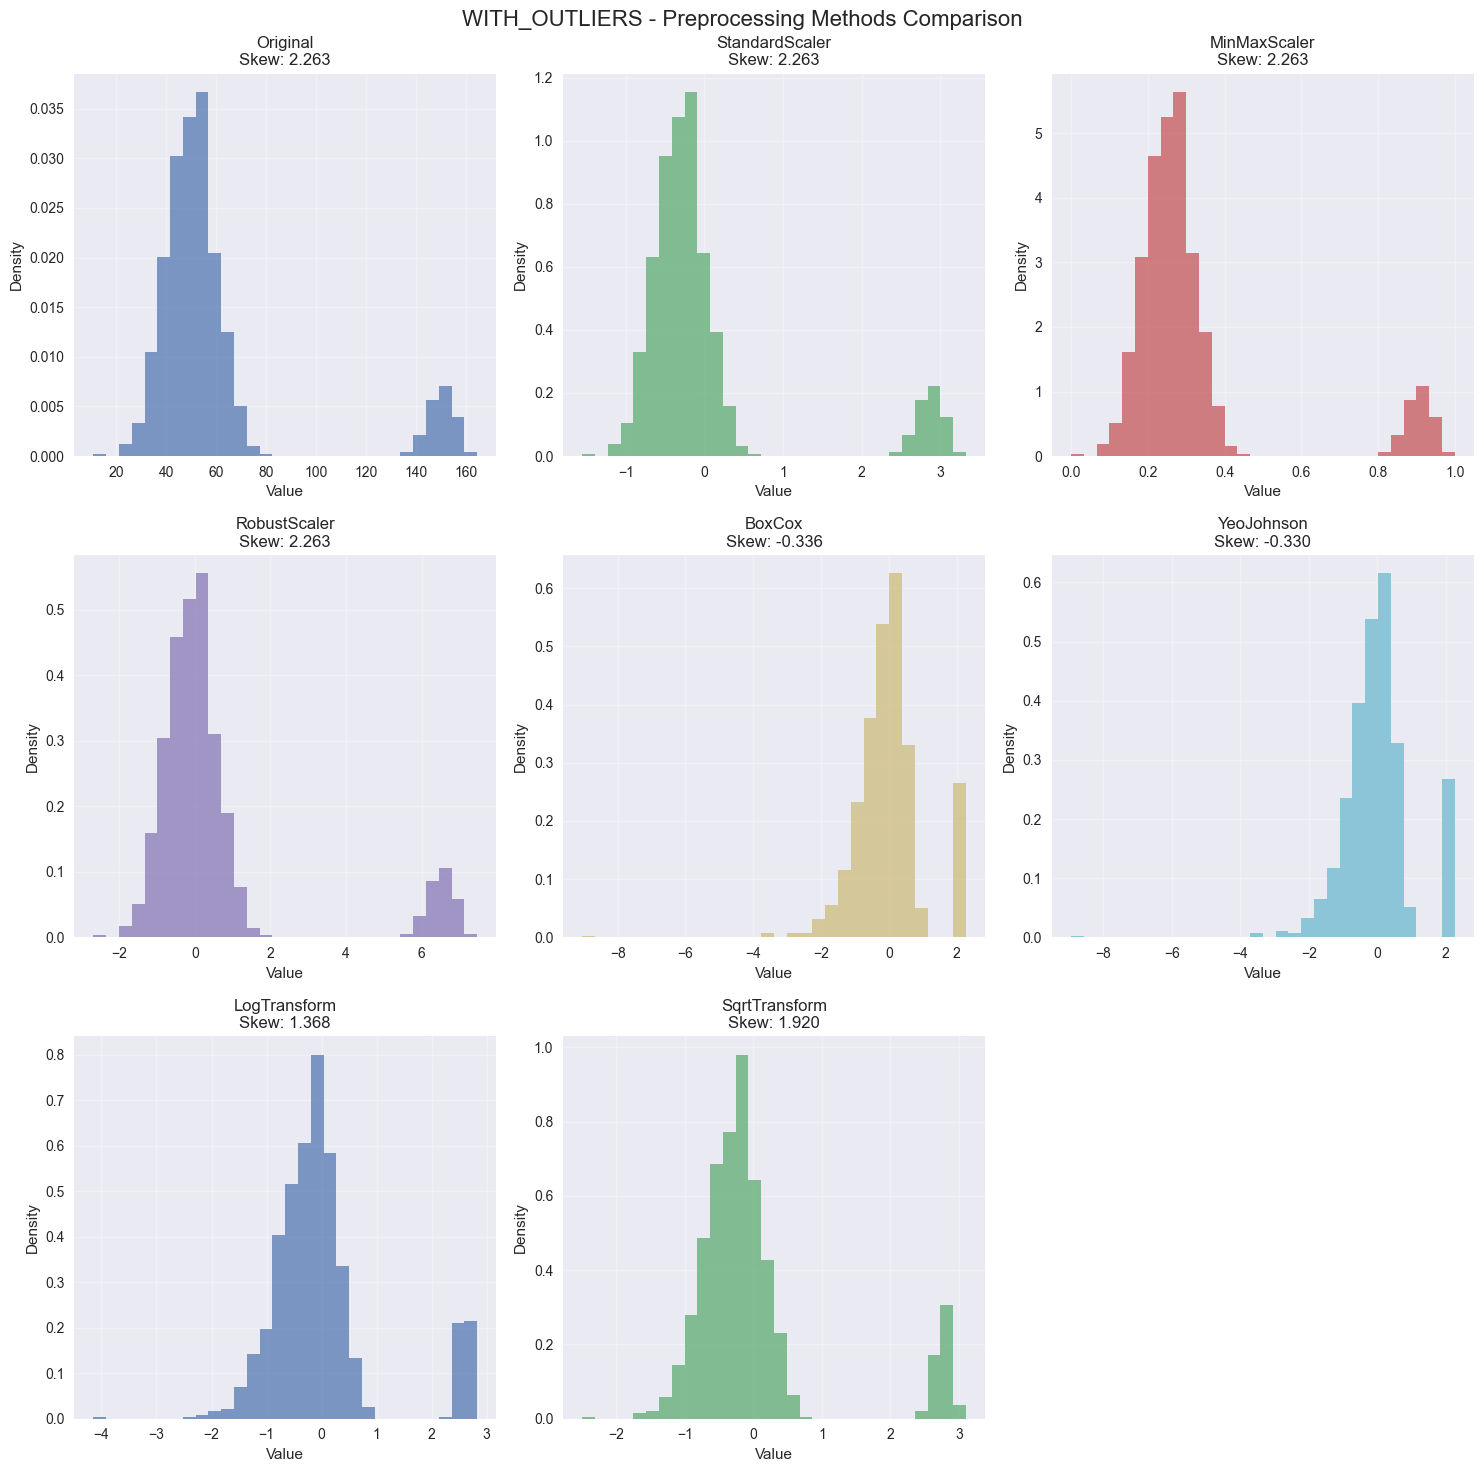

In [9]:
print("\n🎯 실습 2: 전처리 방법별 효과 비교")
preprocessing_results = {}

for name, data in datasets.items():
    methods, results, best_method = compare_preprocessing_methods(data, name)
    preprocessing_results[name] = {
        'methods': methods,
        'results': results,
        'best_method': best_method
    }
    visualize_preprocessing_comparison(methods, name)

실습 3: 실제 회귀 문제에서 전처리 효과 검증

In [17]:
def create_synthetic_housing_data(n_samples=1000, random_state=42):
    """실제적인 주택 가격 데이터 시뮬레이션"""
    np.random.seed(random_state)
    
    # 다양한 분포의 특성 생성
    features = {}
    
    # 1. 범죄율 (지수분포 - 대부분 낮지만 일부 높은 지역)
    features['crime_rate'] = np.random.exponential(3, n_samples)
    
    # 2. 방 개수 (정규분포에 가까움)
    features['room_count'] = np.random.normal(6.5, 1.2, n_samples)
    features['room_count'] = np.clip(features['room_count'], 3, 12)  # 현실적 범위
    
    # 3. 건물 연식 (감마분포)
    features['building_age'] = np.random.gamma(2, 15, n_samples)
    features['building_age'] = np.clip(features['building_age'], 0, 100)
    
    # 4. 소득 수준 (로그정규분포)
    features['income_level'] = np.random.lognormal(np.log(50000), 0.6, n_samples)
    
    # 5. 교통 접근성 (베타분포를 0-10 스케일로)
    features['transport_access'] = np.random.beta(2, 3, n_samples) * 10
    
    # 6. 학군 점수 (이중모드 - 좋은 학군과 보통 학군)
    good_schools_size = n_samples // 3
    avg_schools_size = n_samples - good_schools_size  # 정확한 크기 보장
    
    good_schools = np.random.normal(8.5, 1, good_schools_size)
    avg_schools = np.random.normal(5.5, 1.5, avg_schools_size)
    school_scores = np.concatenate([good_schools, avg_schools])
    np.random.shuffle(school_scores)
    features['school_score'] = np.clip(school_scores, 1, 10)
    
    # 타겟 변수 생성 (가격)
    price = (
        -8000 * features['crime_rate'] +               # 범죄율 높으면 가격 하락
        15000 * features['room_count'] +               # 방 많으면 가격 상승
        -1200 * features['building_age'] +             # 오래될수록 가격 하락
        2.5 * features['income_level'] +               # 소득 높은 지역일수록 비싸
        3000 * features['transport_access'] +          # 교통 좋으면 가격 상승
        8000 * features['school_score'] +              # 학군 좋으면 가격 상승
        np.random.normal(0, 15000, n_samples)          # 노이즈
    )
    
    # 현실적인 가격 범위로 조정
    price = np.clip(price, 100000, 2000000)
    
    # DataFrame 생성
    df = pd.DataFrame(features)
    df['price'] = price
    
    return df

In [18]:
def evaluate_preprocessing_impact(df, target_col='price'):
    """전처리 방법이 회귀 성능에 미치는 영향 평가"""
    print(f"\n🏠 실제 회귀 문제에서의 전처리 효과 검증")
    print("="*60)
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # 학습/테스트 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    preprocessing_methods = {
        'Original': None,
        'StandardScaler': StandardScaler(),
        'RobustScaler': RobustScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'YeoJohnson': PowerTransformer(method='yeo-johnson')
    }
    
    # 모델별 평가
    models = {
        'LinearRegression': LinearRegression(),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for model_name, model in models.items():
        print(f"\n📈 {model_name} 성능 비교:")
        print("-" * 40)
        
        model_results = {}
        
        for prep_name, preprocessor in preprocessing_methods.items():
            try:
                # 전처리 적용
                if preprocessor is None:
                    X_train_prep = X_train
                    X_test_prep = X_test
                else:
                    X_train_prep = preprocessor.fit_transform(X_train)
                    X_test_prep = preprocessor.transform(X_test)
                
                # 모델 학습 및 예측
                model_copy = type(model)(**model.get_params()) if hasattr(model, 'get_params') else model
                model_copy.fit(X_train_prep, y_train)
                y_pred = model_copy.predict(X_test_prep)
                
                # 성능 계산
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                
                model_results[prep_name] = {
                    'MSE': mse,
                    'RMSE': rmse,
                    'MAE': mae,
                    'R2': r2
                }
                
                print(f"{prep_name:15s}: RMSE={rmse:8.0f}, R²={r2:.4f}, MAE={mae:8.0f}")
                
            except Exception as e:
                print(f"{prep_name:15s}: Error - {e}")
        
        results[model_name] = model_results
        
        # 최고 성능 방법
        if model_results:
            best_prep = min(model_results.keys(), key=lambda x: model_results[x]['RMSE'])
            improvement = ((model_results['Original']['RMSE'] - model_results[best_prep]['RMSE']) 
                          / model_results['Original']['RMSE'] * 100)
            print(f"\n🏆 최고 성능: {best_prep}")
            print(f"   RMSE 개선: {improvement:.1f}%")
    
    return results

In [19]:
print("\n🎯 실습 3: 실제 회귀 문제에서 전처리 효과 검증")

# 합성 주택 데이터 생성
housing_data = create_synthetic_housing_data()

print("\n📊 주택 데이터 기본 정보:")
print(housing_data.describe())

print("\n📈 각 특성별 분포 분석:")
for col in housing_data.columns[:-1]:  # 타겟 제외
    stats_summary = analyze_distribution(housing_data[col].values, col)

# 전처리 효과 평가
regression_results = evaluate_preprocessing_impact(housing_data)


🎯 실습 3: 실제 회귀 문제에서 전처리 효과 검증

📊 주택 데이터 기본 정보:
        crime_rate   room_count  building_age   income_level  \
count  1000.000000  1000.000000   1000.000000    1000.000000   
mean      2.917518     6.618681     30.291058   57182.365389   
std       2.917530     1.186702     20.706495   36015.310961   
min       0.013928     3.000000      0.387907    8227.182423   
25%       0.807470     5.823055     14.718159   32557.581106   
50%       2.060348     6.601057     25.893731   49032.567703   
75%       4.091491     7.387558     39.909203   71119.498268   
max      24.517337    10.331729    100.000000  349980.971963   

       transport_access  school_score          price  
count       1000.000000   1000.000000    1000.000000  
mean           4.134571      6.521195  248091.437141  
std            2.029113      1.907694   99924.953895  
min            0.181118      1.718729  100000.000000  
25%            2.531842      5.086219  185061.340122  
50%            4.031388      6.454965  230387.

실습 4: 딥러닝에서 가중치 초기화 전략 비교

In [20]:
class SimpleNN(nn.Module):
    """간단한 피드포워드 신경망"""
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu'):
        super(SimpleNN, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, output_size))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

def initialize_weights(model, method='xavier_uniform'):
    """가중치 초기화 방법 적용"""
    for module in model.modules():
        if isinstance(module, nn.Linear):
            if method == 'xavier_uniform':
                nn.init.xavier_uniform_(module.weight)
            elif method == 'xavier_normal':
                nn.init.xavier_normal_(module.weight)
            elif method == 'he_uniform':
                nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
            elif method == 'he_normal':
                nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
            elif method == 'normal':
                nn.init.normal_(module.weight, mean=0, std=0.1)
            elif method == 'uniform':
                nn.init.uniform_(module.weight, -0.1, 0.1)
            
            if module.bias is not None:
                nn.init.zeros_(module.bias)

In [25]:
def train_and_evaluate_nn(X_train, X_test, y_train, y_test, init_method, 
                         hidden_sizes=[64, 32], epochs=100, lr=0.001):
    """신경망 학습 및 평가"""
    
    # 데이터를 텐서로 변환
    X_train_tensor = torch.FloatTensor(X_train.values if hasattr(X_train, 'values') else X_train)
    X_test_tensor = torch.FloatTensor(X_test.values if hasattr(X_test, 'values') else X_test)
    y_train_tensor = torch.FloatTensor(y_train.values if hasattr(y_train, 'values') else y_train).unsqueeze(1)
    y_test_tensor = torch.FloatTensor(y_test.values if hasattr(y_test, 'values') else y_test).unsqueeze(1)
    # 모델 생성 및 초기화
    model = SimpleNN(X_train.shape[1], hidden_sizes, 1)
    initialize_weights(model, init_method)
    
    # 손실함수와 옵티마이저
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # 학습
    model.train()
    train_losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    # 평가
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train_tensor)
        test_pred = model(X_test_tensor)
        
        train_loss = criterion(train_pred, y_train_tensor).item()
        test_loss = criterion(test_pred, y_test_tensor).item()
        
        # R² 계산
        train_r2 = r2_score(y_train, train_pred.numpy())
        test_r2 = r2_score(y_test, test_pred.numpy())
    
    return {
        'train_loss': train_loss,
        'test_loss': test_loss,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_losses': train_losses
    }

In [26]:
def compare_weight_initialization(df, target_col='price'):
    """가중치 초기화 방법별 성능 비교"""
    print(f"\n🧠 딥러닝 가중치 초기화 전략 비교")
    print("="*50)
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # 데이터 정규화 (딥러닝을 위해)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
    
    X_train, X_test, y_train, y_test = train_test_split(
        pd.DataFrame(X_scaled), pd.Series(y_scaled), test_size=0.2, random_state=42)
    
    # 초기화 방법들
    init_methods = [
        'xavier_uniform', 'xavier_normal', 
        'he_uniform', 'he_normal',
        'normal', 'uniform'
    ]
    
    init_results = {}
    
    for method in init_methods:
        print(f"\n🔧 Testing {method} initialization...")
        
        # 여러 번 실행하여 평균 성능 계산 (확률적 특성 때문)
        results_list = []
        for run in range(3):  # 3번 실행
            result = train_and_evaluate_nn(
                X_train, X_test, y_train, y_test, 
                method, epochs=50, lr=0.001
            )
            results_list.append(result)
        
        # 평균 성능 계산
        avg_result = {
            'train_loss': np.mean([r['train_loss'] for r in results_list]),
            'test_loss': np.mean([r['test_loss'] for r in results_list]),
            'train_r2': np.mean([r['train_r2'] for r in results_list]),
            'test_r2': np.mean([r['test_r2'] for r in results_list]),
            'std_test_loss': np.std([r['test_loss'] for r in results_list])
        }
        
        init_results[method] = avg_result
        
        print(f"   Test Loss: {avg_result['test_loss']:.4f} ± {avg_result['std_test_loss']:.4f}")
        print(f"   Test R²: {avg_result['test_r2']:.4f}")
    # 결과 요약
    print(f"\n📊 가중치 초기화 방법별 성능 요약:")
    print("-" * 60)
    print(f"{'Method':<15} {'Test Loss':<12} {'Test R²':<10} {'Overfitting':<12}")
    print("-" * 60)
    
    for method, result in init_results.items():
        overfitting = result['train_loss'] - result['test_loss']
        print(f"{method:<15} {result['test_loss']:<12.4f} {result['test_r2']:<10.4f} {overfitting:<12.4f}")
    
    # 최고 성능 방법
    best_method = min(init_results.keys(), key=lambda x: init_results[x]['test_loss'])
    print(f"\n🏆 최고 성능 초기화 방법: {best_method}")
    print(f"   Test Loss: {init_results[best_method]['test_loss']:.4f}")
    print(f"   Test R²: {init_results[best_method]['test_r2']:.4f}")
    
    return init_results
    

In [27]:
# 실습 4 실행
print("\n🎯 실습 4: 딥러닝 가중치 초기화 전략 비교")
if 'housing_data' in locals():
    weight_init_results = compare_weight_initialization(housing_data)


🎯 실습 4: 딥러닝 가중치 초기화 전략 비교

🧠 딥러닝 가중치 초기화 전략 비교

🔧 Testing xavier_uniform initialization...
   Test Loss: 0.0479 ± 0.0056
   Test R²: 0.9451

🔧 Testing xavier_normal initialization...
   Test Loss: 0.0424 ± 0.0036
   Test R²: 0.9514

🔧 Testing he_uniform initialization...
   Test Loss: 0.1198 ± 0.0288
   Test R²: 0.8627

🔧 Testing he_normal initialization...
   Test Loss: 0.1332 ± 0.0297
   Test R²: 0.8474

🔧 Testing normal initialization...
   Test Loss: 0.1443 ± 0.0582
   Test R²: 0.8347

🔧 Testing uniform initialization...
   Test Loss: 0.2435 ± 0.0287
   Test R²: 0.7210

📊 가중치 초기화 방법별 성능 요약:
------------------------------------------------------------
Method          Test Loss    Test R²    Overfitting 
------------------------------------------------------------
xavier_uniform  0.0479       0.9451     0.0068      
xavier_normal   0.0424       0.9514     0.0075      
he_uniform      0.1198       0.8627     -0.0123     
he_normal       0.1332       0.8474     -0.0077     
normal    

실습 5: VAE의 잠재공간 분포 실험

In [28]:
class SimpleVAE(nn.Module):
    """간단한 VAE 구현"""
    def __init__(self, input_dim, latent_dim, hidden_dim=128):
        super(SimpleVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU()
        )
        
        # 잠재 변수 파라미터
        self.fc_mu = nn.Linear(hidden_dim//2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim//2, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [29]:
def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    """VAE 손실함수 (ELBO)"""
    # 재구성 손실 (Reconstruction Loss)
    recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)
    
    # KL Divergence 손실
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + beta * kl_loss, recon_loss, kl_loss


In [30]:
def train_vae_with_different_priors(X_data, latent_dim=2, epochs=100, beta=1.0):
    """다른 사전분포로 VAE 학습"""
    print(f"\n🎨 VAE 잠재공간 분포 실험 (β={beta})")
    print("-" * 40)
    
    # 데이터 준비
    X_tensor = torch.FloatTensor(X_data)
    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # VAE 모델
    vae = SimpleVAE(X_data.shape[1], latent_dim)
    optimizer = optim.Adam(vae.parameters(), lr=1e-3)
    
    # 학습
    vae.train()
    losses = {'total': [], 'recon': [], 'kl': []}
    
    for epoch in range(epochs):
        epoch_losses = {'total': 0, 'recon': 0, 'kl': 0}
        
        for batch_data, in dataloader:
            optimizer.zero_grad()
            
            recon_batch, mu, logvar = vae(batch_data)
            total_loss, recon_loss, kl_loss = vae_loss_function(
                recon_batch, batch_data, mu, logvar, beta
            )
            
            total_loss.backward()
            optimizer.step()
            
            epoch_losses['total'] += total_loss.item()
            epoch_losses['recon'] += recon_loss.item()
            epoch_losses['kl'] += kl_loss.item()
        
        # 평균 손실 저장
        for key in losses:
            losses[key].append(epoch_losses[key] / len(dataloader))
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1:3d}: Total={losses['total'][-1]:.2f}, "
                  f"Recon={losses['recon'][-1]:.2f}, KL={losses['kl'][-1]:.2f}")
    
    # 잠재공간 분석
    vae.eval()
    with torch.no_grad():
        mu, logvar = vae.encode(X_tensor)
        z_samples = vae.reparameterize(mu, logvar)
    
    return vae, losses, z_samples.numpy(), mu.numpy(), logvar.numpy()

In [31]:
def analyze_latent_space(z_samples, mu, logvar, beta):
    """잠재공간 분석 및 시각화"""
    print(f"\n📊 잠재공간 분석 (β={beta}):")
    
    # 잠재변수 통계
    print(f"Latent variable statistics:")
    for i in range(z_samples.shape[1]):
        z_mean = np.mean(z_samples[:, i])
        z_std = np.std(z_samples[:, i])
        print(f"  z_{i}: mean={z_mean:.3f}, std={z_std:.3f}")
    
    # KL divergence 분석
    kl_div = -0.5 * np.sum(1 + logvar - mu**2 - np.exp(logvar), axis=1)
    print(f"Average KL divergence per sample: {np.mean(kl_div):.3f}")
    
    # 시각화 (2D 잠재공간인 경우)
    if z_samples.shape[1] == 2:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # 1. 잠재공간 산점도
        axes[0].scatter(z_samples[:, 0], z_samples[:, 1], alpha=0.6, s=20)
        axes[0].set_title(f'Latent Space (β={beta})')
        axes[0].set_xlabel('z_0')
        axes[0].set_ylabel('z_1')
        axes[0].grid(True, alpha=0.3)
        
        # 표준정규분포 등고선 추가
        x = np.linspace(-3, 3, 100)
        y = np.linspace(-3, 3, 100)
        X, Y = np.meshgrid(x, y)
        Z = np.exp(-0.5 * (X**2 + Y**2)) / (2 * np.pi)
        axes[0].contour(X, Y, Z, colors='red', alpha=0.5, linestyles='--')
        
        # 2. 각 차원별 분포
        axes[1].hist(z_samples[:, 0], bins=30, alpha=0.7, density=True, label='z_0')
        axes[1].hist(z_samples[:, 1], bins=30, alpha=0.7, density=True, label='z_1')
        
        # 표준정규분포 곡선 추가
        x_norm = np.linspace(-4, 4, 100)
        y_norm = stats.norm.pdf(x_norm, 0, 1)
        axes[1].plot(x_norm, y_norm, 'r--', label='N(0,1)')
        
        axes[1].set_title('Latent Dimensions Distribution')
        axes[1].set_xlabel('Value')
        axes[1].set_ylabel('Density')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # 3. Q-Q plot for normality check
        stats.probplot(z_samples[:, 0], dist="norm", plot=axes[2])
        axes[2].set_title('Q-Q Plot (z_0 vs Normal)')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

In [32]:
def experiment_beta_vae(X_data):
    """β-VAE 실험: 다른 β 값의 효과 비교"""
    print(f"\n🔬 β-VAE 실험: Disentanglement vs Reconstruction Trade-off")
    print("="*70)
    
    beta_values = [0.1, 1.0, 4.0, 10.0]
    results = {}
    
    for beta in beta_values:
        print(f"\n🧪 β = {beta} 실험 중...")
        vae, losses, z_samples, mu, logvar = train_vae_with_different_priors(
            X_data, latent_dim=2, epochs=50, beta=beta
        )
        
        results[beta] = {
            'vae': vae,
            'losses': losses,
            'z_samples': z_samples,
            'mu': mu,
            'logvar': logvar
        }
        
        analyze_latent_space(z_samples, mu, logvar, beta)
    
    # β 값별 손실 비교
    plt.figure(figsize=(15, 5))
    
    # 1. 총 손실
    plt.subplot(1, 3, 1)
    for beta in beta_values:
        plt.plot(results[beta]['losses']['total'], label=f'β={beta}')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. 재구성 손실
    plt.subplot(1, 3, 2)
    for beta in beta_values:
        plt.plot(results[beta]['losses']['recon'], label=f'β={beta}')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. KL 손실
    plt.subplot(1, 3, 3)
    for beta in beta_values:
        plt.plot(results[beta]['losses']['kl'], label=f'β={beta}')
    plt.title('KL Divergence Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results



🎯 실습 5: VAE 잠재공간 분포 실험

🔬 β-VAE 실험: Disentanglement vs Reconstruction Trade-off

🧪 β = 0.1 실험 중...

🎨 VAE 잠재공간 분포 실험 (β=0.1)
----------------------------------------
Epoch  20: Total=97.45, Recon=84.65, KL=128.06
Epoch  40: Total=87.13, Recon=73.22, KL=139.13

📊 잠재공간 분석 (β=0.1):
Latent variable statistics:
  z_0: mean=0.028, std=1.018
  z_1: mean=-0.094, std=1.039
Average KL divergence per sample: 4.541


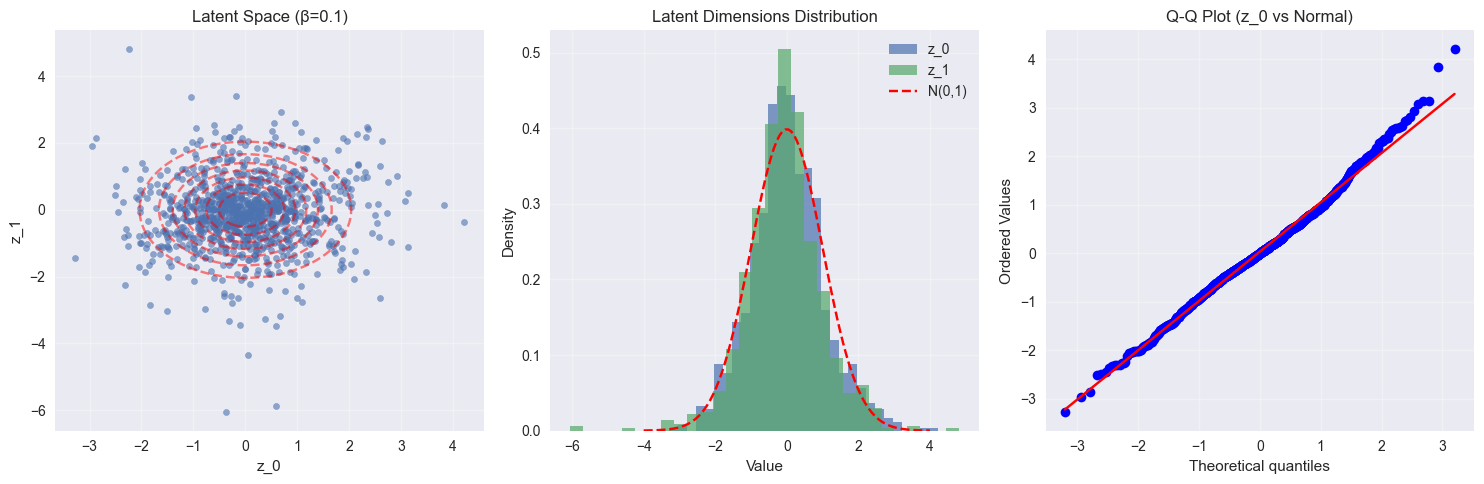


🧪 β = 1.0 실험 중...

🎨 VAE 잠재공간 분포 실험 (β=1.0)
----------------------------------------
Epoch  20: Total=162.19, Recon=123.06, KL=39.12
Epoch  40: Total=159.95, Recon=119.32, KL=40.63

📊 잠재공간 분석 (β=1.0):
Latent variable statistics:
  z_0: mean=-0.036, std=0.990
  z_1: mean=-0.050, std=1.013
Average KL divergence per sample: 1.405


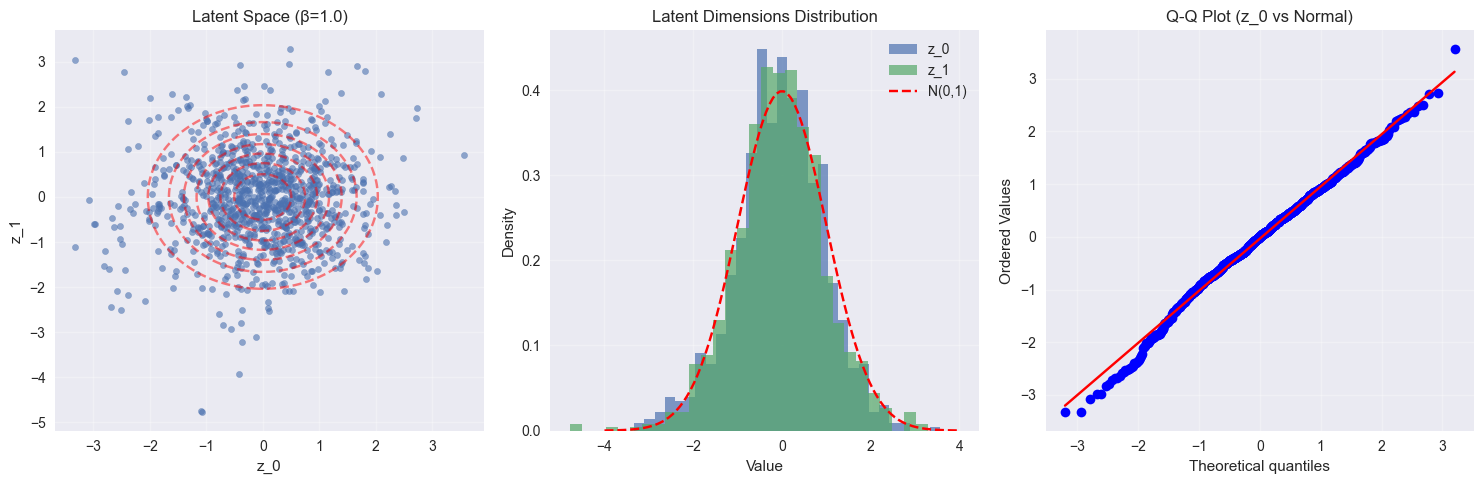


🧪 β = 4.0 실험 중...

🎨 VAE 잠재공간 분포 실험 (β=4.0)
----------------------------------------
Epoch  20: Total=187.85, Recon=187.80, KL=0.01
Epoch  40: Total=187.70, Recon=187.68, KL=0.01

📊 잠재공간 분석 (β=4.0):
Latent variable statistics:
  z_0: mean=-0.018, std=0.979
  z_1: mean=0.085, std=0.997
Average KL divergence per sample: 0.001


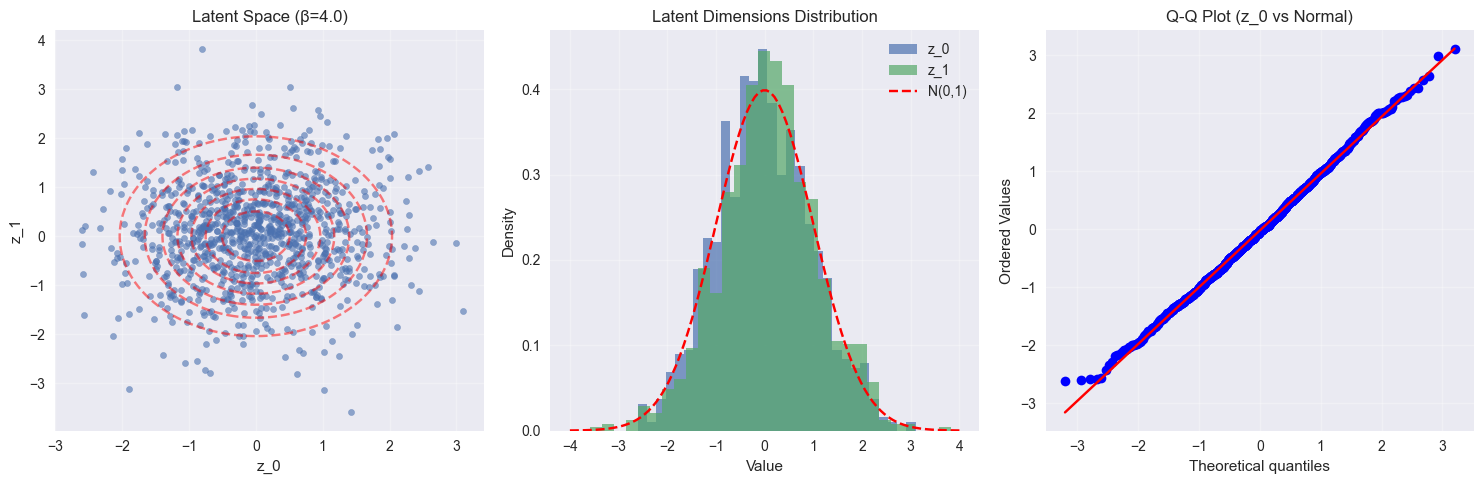


🧪 β = 10.0 실험 중...

🎨 VAE 잠재공간 분포 실험 (β=10.0)
----------------------------------------
Epoch  20: Total=188.04, Recon=187.97, KL=0.01
Epoch  40: Total=187.65, Recon=187.62, KL=0.00

📊 잠재공간 분석 (β=10.0):
Latent variable statistics:
  z_0: mean=-0.001, std=1.028
  z_1: mean=0.020, std=1.032
Average KL divergence per sample: 0.000


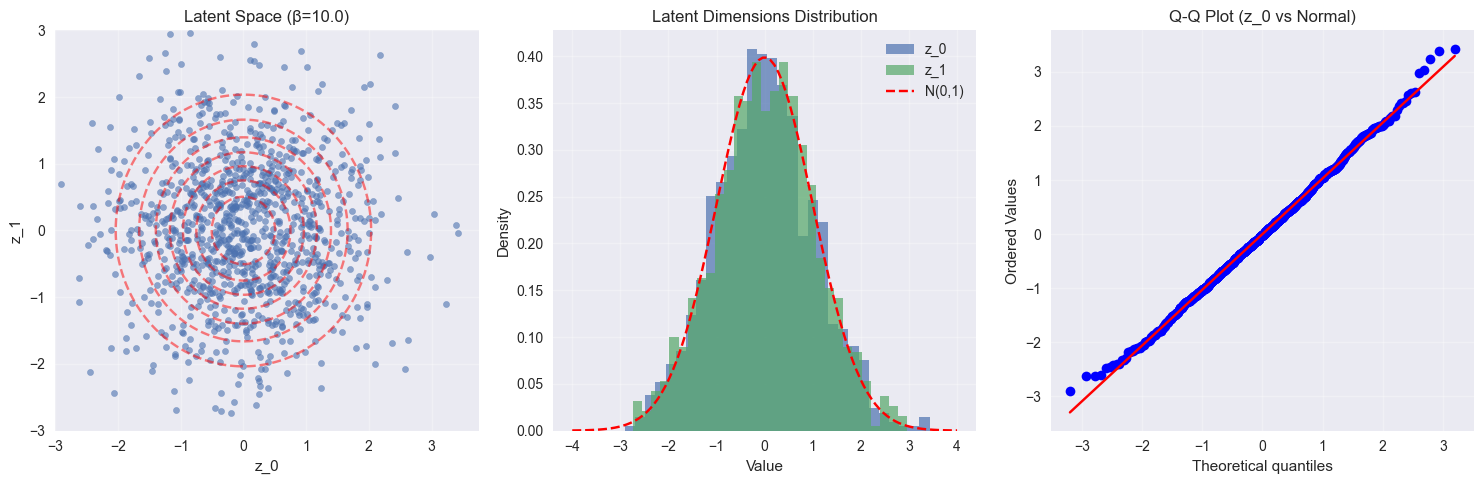

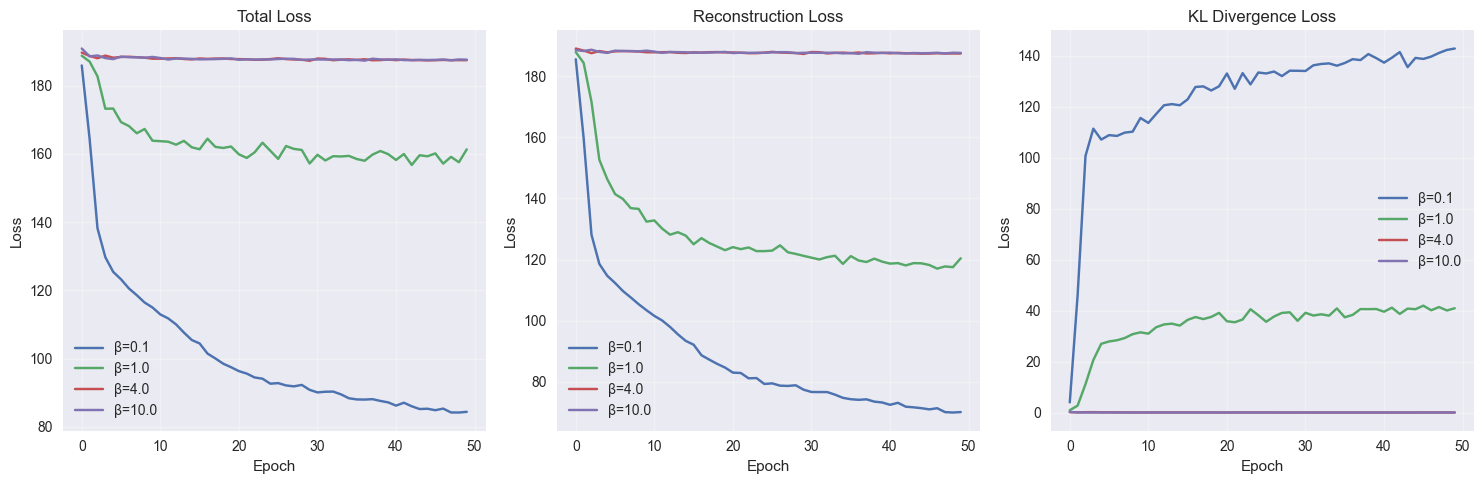

In [33]:
# 실습 5 실행
print("\n🎯 실습 5: VAE 잠재공간 분포 실험")

# 주택 데이터로 VAE 실험
if 'housing_data' in locals():
    # 특성 데이터만 사용 (타겟 제외)
    X_housing = housing_data.drop(columns=['price']).values
    
    # 데이터 정규화
    scaler = StandardScaler()
    X_housing_scaled = scaler.fit_transform(X_housing)
    
    # β-VAE 실험
    beta_vae_results = experiment_beta_vae(X_housing_scaled)

실습 6: 정보 이론 기반 특성 선택

In [ ]:
def calculate_mutual_information(X, y, n_bins=10):
    """상호정보량 계산 (이산화를 통한 근사)"""
    from sklearn.feature_selection import mutual_info_regression
    
    # sklearn의 mutual_info_regression 사용
    mi_scores = mutual_info_regression(X, y, random_state=42)
    
    return mi_scores

def entropy_based_feature_selection(df, target_col='price', top_k=3):
    """엔트로피와 상호정보량 기반 특성 선택"""
    print(f"\n📊 정보 이론 기반 특성 선택")
    print("="*50)
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # 상호정보량 계산
    mi_scores = calculate_mutual_information(X.values, y.values)
    
    # 결과 정리
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'mutual_info': mi_scores
    }).sort_values('mutual_info', ascending=False)
    
    print(f"특성별 상호정보량 (타겟과의 정보 공유량):")
    print("-" * 40)
    for idx, row in feature_importance.iterrows():
        print(f"{row['feature']:<20}: {row['mutual_info']:.4f}")
    
    # 상위 특성들로 회귀 성능 비교
    print(f"\n🔍 Top-{top_k} 특성으로 회귀 성능 비교:")
    
    top_features = feature_importance.head(top_k)['feature'].tolist()
    
    # 전체 특성 vs 선택된 특성 성능 비교
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 전체 특성
    lr_full = LinearRegression()
    lr_full.fit(X_train, y_train)
    y_pred_full = lr_full.predict(X_test)
    r2_full = r2_score(y_test, y_pred_full)
    
    # 선택된 특성
    lr_selected = LinearRegression()
    lr_selected.fit(X_train[top_features], y_train)
    y_pred_selected = lr_selected.predict(X_test[top_features])
    r2_selected = r2_score(y_test, y_pred_selected)
    
    print(f"전체 특성 ({len(X.columns)}개): R² = {r2_full:.4f}")
    print(f"선택 특성 ({top_k}개): R² = {r2_selected:.4f}")
    print(f"성능 차이: {r2_selected - r2_full:.4f}")
    
    # 시각화
    plt.figure(figsize=(12, 8))
    
    # 1. 상호정보량 막대그래프
    plt.subplot(2, 2, 1)
    plt.barh(feature_importance['feature'], feature_importance['mutual_info'])
    plt.title('Mutual Information with Target')
    plt.xlabel('Mutual Information Score')
    
    # 2. 상위 특성들의 타겟과의 산점도
    for i, feature in enumerate(top_features[:3]):
        plt.subplot(2, 3, 4 + i)
        plt.scatter(df[feature], df[target_col], alpha=0.6, s=20)
        plt.xlabel(feature)
        plt.ylabel(target_col)
        plt.title(f'{feature} vs {target_col}')
        
        # 회귀선 추가
        z = np.polyfit(df[feature], df[target_col], 1)
        p = np.poly1d(z)
        plt.plot(df[feature].sort_values(), p(df[feature].sort_values()), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    return feature_importance, top_features

# 실습 6 실행
print("\n🎯 실습 6: 정보 이론 기반 특성 선택")
if 'housing_data' in locals():
    feature_ranking, selected_features = entropy_based_feature_selection(housing_data)


종합 결과 요약 및 권장사항

In [ ]:
def generate_comprehensive_report():
    """종합 분석 보고서 생성"""
    print(f"\n📋 4일차 실습 종합 분석 보고서")
    print("="*60)
    
    print(f"\n1. 🔍 분포별 특성 분석 결과:")
    print("-" * 30)
    for name, stats in distribution_stats.items():
        normality = "Normal" if (stats.get('shapiro_p', 0) > 0.05) else "Non-normal"
        skew_type = "Symmetric" if abs(stats['skewness']) < 0.5 else \
                   ("Right-skewed" if stats['skewness'] > 0 else "Left-skewed")
        print(f"  {name:12s}: {normality:10s}, {skew_type}")
    
    print(f"\n2. 🔧 전처리 방법 권장사항:")
    print("-" * 30)
    for name, result in preprocessing_results.items():
        if result['best_method']:
            print(f"  {name:12s}: {result['best_method']}")
    
    print(f"\n3. 🏠 회귀 성능에서 전처리 효과:")
    print("-" * 30)
    if 'regression_results' in locals():
        for model, results in regression_results.items():
            best_prep = min(results.keys(), key=lambda x: results[x]['RMSE'])
            improvement = ((results['Original']['RMSE'] - results[best_prep]['RMSE']) 
                          / results['Original']['RMSE'] * 100)
            print(f"  {model:15s}: {best_prep} ({improvement:.1f}% 개선)")
    
    print(f"\n4. 🧠 딥러닝 가중치 초기화:")
    print("-" * 30)
    if 'weight_init_results' in locals():
        best_init = min(weight_init_results.keys(), 
                       key=lambda x: weight_init_results[x]['test_loss'])
        print(f"  최적 방법: {best_init}")
        print(f"  성능: R² = {weight_init_results[best_init]['test_r2']:.4f}")
    
    print(f"\n5. 🎨 VAE β 값 효과:")
    print("-" * 30)
    if 'beta_vae_results' in locals():
        print(f"  β = 0.1: 재구성 중시 (높은 품질, 낮은 regularization)")
        print(f"  β = 1.0: 균형적 접근 (표준 VAE)")
        print(f"  β > 4.0: 분리표현 중시 (높은 regularization)")
    
    print(f"\n6. 📊 특성 중요도 (상호정보량):")
    print("-" * 30)
    if 'feature_ranking' in locals():
        for idx, row in feature_ranking.head(3).iterrows():
            print(f"  {row['feature']:15s}: {row['mutual_info']:.4f}")
    
    print(f"\n💡 주요 인사이트:")
    print("-" * 30)
    print(f"  • 치우친 분포는 Box-Cox나 Yeo-Johnson 변환이 효과적")
    print(f"  • 이상치가 많은 데이터는 RobustScaler 추천")
    print(f"  • ReLU 활성화 함수에는 He 초기화가 적합")
    print(f"  • VAE에서 β 값은 재구성과 분리표현의 trade-off 조절")
    print(f"  • 상호정보량은 비선형 관계도 잘 포착함")

# 종합 보고서 생성
generate_comprehensive_report()

print(f"\n🎉 4일차 실습 완료!")
print(f"다음 단계: 정보 이론 심화 (엔트로피, KL Divergence 실습)")
print("="*60)